# News Recommendation System - By Javali Murari

#### Problem Statement:

iPrint is an upcoming media house in India that offers media and information services to the people. The company’s business extends across a wide range of media, including news and information services on sports, weather, education, health, research, stocks and healthcare. It was not able to recommend any new content to its customers, and gradually, the company started losing such users, which eventually resulted in immense revenue loss. 

iPrint being a cutting-edge company, is trying to solve this issue of revenue leakage by personalising user tastes and introducing new content to its users at the start of the day on the home page of the application. iPrint is planning to assess these recommendations by tracking whether the user clicks on those items or not. Moreover, once the user clicks on any news item A, it wants to recommend news similar to the news A, at the bottom of the page of the news item A. 

Essentially, the company wants —

- Recommend new top 10 relevant articles to a user when he visits the app at the start of the day
- Recommend top 10 similar news articles that match the ones clicked by the user, using different models for generating these recommendations and experiment with hybrid models for the same
- Have to ensure that the system does not recommend any news article that has been pulled out from the app or has already been seen by the user. 
- The final generated list must contain the names of the recommended articles, along with their IDs.

## 0 - Import relevant Python Libraries

In [1]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

#importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import os
import implicit

import nltk
nltk.download('stopwords')

from implicit.evaluation import train_test_split
from sklearn.model_selection import train_test_split as train_test
from sklearn.metrics.pairwise import pairwise_distances
from IPython.display import Image
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from math import sqrt
from scipy.sparse import csr_matrix
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.similarities import MatrixSimilarity
from nltk.corpus import stopwords

# Set display options
pd.set_option('max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\murar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1 Reading & Analyzing the Datasets

### 1.1 Loading consumer_transanctions Dataset & Features analysis

In [2]:
# Load Consumers Tansactions Data

consumers = pd.read_csv("consumer_transanctions.csv")

# print the Shape
consumers.shape

(72312, 8)

In [3]:
# Dataframe column information

consumers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       72312 non-null  int64 
 1   interaction_type      72312 non-null  object
 2   item_id               72312 non-null  int64 
 3   consumer_id           72312 non-null  int64 
 4   consumer_session_id   72312 non-null  object
 5   consumer_device_info  56918 non-null  object
 6   consumer_location     56907 non-null  object
 7   country               56918 non-null  object
dtypes: int64(3), object(5)
memory usage: 4.4+ MB


- There are 3 Numerical columns and 5 categorical columns
- There are missing values in the Categorical columns

In [4]:
# Basic statistical information

consumers.describe()

,event_timestamp,item_id,consumer_id
count,7.231200e+04,7.231200e+04,7.231200e+04
mean,1.470103e+09,-3.033423e+16,1.252026e+16
std,7.258130e+06,5.344755e+18,5.022333e+18
min,1.457964e+09,-9.222795e+18,-9.223122e+18
25%,1.464876e+09,-4.726309e+18,-3.596627e+18
50%,1.468343e+09,1.893099e+16,-1.088422e+17
75%,1.474461e+09,4.441012e+18,3.766319e+18
max,1.488310e+09,9.222265e+18,9.210531e+18


- event_timestamp has no relevance
- Item_id, consumer_id are IDs of numeric type. So we will convert the dtype to char for better reporting

In [5]:
# Let's explore uniqueness of all columns

consumers.nunique()

event_timestamp         68772
interaction_type            5
item_id                  2987
consumer_id              1895
consumer_session_id     28909
consumer_device_info     1090
consumer_location          71
country                    23
dtype: int64

- We can see lot of disparity between total no of records and event_timestamp/consumer_session_id, which indicates the duplication of records

In [6]:
# Let's see Sample data

consumers.sample(10)

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
13987,1466454921,content_watched,4788854083489560153,6874219153545533301,3021748406491849637,NaN,NaN,NaN
26655,1461166198,content_liked,-2871288807409592,-1602833675167376798,4040050546383903697,NaN,NaN,NaN
10538,1464219857,content_watched,-3170783292462058942,-5867382161915898777,1271088027541273501,"Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_2 like Mac OS X) AppleWebKit/601.1.46 (KHTML, like Gecko) Version/9.0 Mobile/13F69 Safari/601.1",SP,BR
15486,1466080659,content_watched,-3581194288660477595,-2511855597392146401,1417391576706325650,"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.84 Safari/537.36",MG,BR
13838,1462296173,content_commented_on,1318981494172475806,-8845298781299428018,-1096019825082524173,NaN,NaN,NaN
23360,1467303837,content_watched,2267321579404324900,7392990465409599343,-114782005239527248,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.49 Safari/537.36",SP,BR
26372,1465955311,content_watched,-8370744479086515302,-867171338823652769,2852896800485881090,NaN,NaN,NaN
39995,1470323510,content_watched,4105873627900556540,-7240735065448254654,-4644829571826792984,"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.82 Safari/537.36",SP,BR
29860,1466171940,content_watched,5658521282502533116,212272079522596410,-8530221144041051435,NaN,NaN,NaN
34823,1468441724,content_watched,-6643406494673362190,5030175185311671155,-5001937044522617788,"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36",CA,US


- event_timestamp is not relevant to the business problem, so we will drop it
- interaction_type - Need to be analysed further
- item_id,consumer_id - We can see these IDs are in normalized form, so we will need to convert to real nos
- consumer_session_id is not relevant to the business problem, so we will drop it
- consumer_device_info - Need to be analysed further
- consumer_location, country - Has many missing values. To be dropped after EDA
- We can see that consumers have reacted to the same article many times, so we will need to drop these duplicates 

In [7]:
# Let's check value counts of "interaction_type","item_id","consumer_id" which are key columns
# for the business problem

consumers[["interaction_type","item_id","consumer_id"]].value_counts().head(10)

interaction_type  item_id               consumer_id         
content_saved     -330801551666885085   -709287718034731589     76
content_watched   -6642751159620064055   2947963873628556360    46
                  -133139342397538859    983095443598229476     44
                  -5879360586463363298  -8652741825481604192    38
                   3367026768872537336  -5088875531913232577    37
                  -1633984990770981161   2195040187466632600    36
                   3739926497176994524   8676130229735483748    32
                  -5920475612630001479   2754566407772265068    32
                   4105873627900556540   2530443148414180019    31
                  -7294716554902079523   4227773676394505435    30
dtype: int64

In [8]:
# Let's consider consumer -330801551666885085 to analyse further

consumers[(consumers["item_id"]==-330801551666885085) & (consumers["consumer_id"]==-709287718034731589)]

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
4650,1465681543,content_saved,-330801551666885085,-709287718034731589,-1424527253526269635,NaN,NaN,NaN
4654,1465681555,content_saved,-330801551666885085,-709287718034731589,-1424527253526269635,NaN,NaN,NaN
4661,1465681525,content_saved,-330801551666885085,-709287718034731589,-1424527253526269635,NaN,NaN,NaN
4666,1465681547,content_saved,-330801551666885085,-709287718034731589,-1424527253526269635,NaN,NaN,NaN
4672,1465681535,content_saved,-330801551666885085,-709287718034731589,-1424527253526269635,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
32042,1465687783,content_liked,-330801551666885085,-709287718034731589,-1424527253526269635,NaN,NaN,NaN
32047,1465687825,content_saved,-330801551666885085,-709287718034731589,-1424527253526269635,NaN,NaN,NaN
32048,1465687828,content_saved,-330801551666885085,-709287718034731589,-1424527253526269635,NaN,NaN,NaN
32049,1465687787,content_liked,-330801551666885085,-709287718034731589,-1424527253526269635,NaN,NaN,NaN


- So we confirmed that consumer has recated to the same article many times, so we will drop duplicates

In [9]:
# Dropping duplicates

consumers=consumers.drop_duplicates(subset=["interaction_type","item_id","consumer_id"], keep='first')
consumers.shape

(50938, 8)

In [10]:
# Understanding interaction_type values

consumers.interaction_type.value_counts(dropna=False)

content_watched         40241
content_liked            5670
content_saved            2202
content_commented_on     1427
content_followed         1398
Name: interaction_type, dtype: int64

- Most of the consumers did not react to the news article after watching it
- 1398 consumers liked the content very much and followed content further

In [11]:
# Exploring consumer_id column. Top5 consumers

consumers[consumers.interaction_type=="content_watched"].consumer_id.value_counts().head()

 3609194402293569455    961
-2626634673110551643    669
-1032019229384696495    642
-1443636648652872475    585
-2979881261169775358    437
Name: consumer_id, dtype: int64

In [12]:
# consumers interaction_type

consumers[["interaction_type","consumer_id"]].value_counts(dropna=False)

interaction_type  consumer_id         
content_watched    3609194402293569455    961
                  -2626634673110551643    669
                  -1032019229384696495    642
                  -1443636648652872475    585
                  -2979881261169775358    437
                                         ... 
content_liked     -5087878572343192653      1
                  -5070718731712624222      1
                  -5052218473217969334      1
content_saved     -3275942195366018617      1
content_watched    607460302441631358       1
Length: 3819, dtype: int64

In [13]:
# Top 3 consumers in each interaction category

Top3=consumers[["interaction_type","consumer_id"]].value_counts().reset_index().sort_values(by=["interaction_type",0],\
                                                        ascending=False).groupby(by=["interaction_type"]).head(3)
Top3

,interaction_type,consumer_id,0
0,content_watched,3609194402293569455,961
1,content_watched,-2626634673110551643,669
2,content_watched,-1032019229384696495,642
58,content_saved,-709287718034731589,127
130,content_saved,-1032019229384696495,71
187,content_saved,801895594717772308,52
14,content_liked,-1032019229384696495,285
41,content_liked,-1602833675167376798,161
52,content_liked,-3390049372067052505,135
123,content_followed,-1032019229384696495,74


In [14]:
# Exploring item_id column. Top 5 News Articles watched

consumers[consumers.interaction_type=="content_watched"].item_id.value_counts().head()

-4029704725707465084    267
-6783772548752091658    193
-133139342397538859     191
 7507067965574797372    148
-8208801367848627943    143
Name: item_id, dtype: int64

In [15]:
# Exploring session id column

consumers.consumer_session_id.value_counts().head()

5983514973000434140     47
890804284397351990      42
-8148041315703601661    35
1857644658478961468     34
-6740458969699172088    29
Name: consumer_session_id, dtype: int64

- This column has no significance to the business problem, hence we will drop the column

In [16]:
# Exploring the consumer_device_info column

consumers.consumer_device_info.value_counts(dropna=False).head()

NaN                                                                                                               11107
Android - Native Mobile App                                                                                        4000
Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36     1330
Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36      898
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36           852
Name: consumer_device_info, dtype: int64

- consumer_device_info column is too large. Hence for better visualization, we will extract devise os from the whole description, though it has no relevance towards the business problem

In [17]:
# Exploring the consumer_location column

consumers.consumer_location.value_counts(dropna=False).head()

SP     28013
NaN    11116
MG      7464
NY       709
GA       660
Name: consumer_location, dtype: int64

In [18]:
# Exploring country feature

consumers.country.value_counts(dropna=False).head(10)

BR     36120
NaN    11107
US      3073
KR       189
CA       166
JP       112
AU        99
GB        14
ZZ         9
IE         8
Name: country, dtype: int64

- Brazilians watched the content more than any other nationalities.
- 11107 consumers have missing country values 
- This column has no significance towards the business problem, so we will drop after EDA

In [19]:
# Top 3 consumers in each counry and their behaviour

Top3=consumers[["interaction_type","consumer_id","country"]].value_counts(dropna=False).reset_index()
Top3=Top3.sort_values(by=["interaction_type","consumer_id","country",0], ascending=False).groupby(by=["interaction_type"]).head(3)
Top3

,interaction_type,consumer_id,country,0
138,content_watched,9210530975708218054,BR,62
804,content_watched,9199170757466086545,BR,13
3944,content_watched,9199170757466086545,NaN,1
1418,content_saved,9210530975708218054,BR,6
3019,content_saved,9210530975708218054,NaN,2
4398,content_saved,9187866633451383747,NaN,1
1352,content_liked,9210530975708218054,BR,7
1828,content_liked,9210530975708218054,NaN,4
3015,content_liked,9191849144618614467,BR,2
1774,content_followed,9210530975708218054,BR,5


- Brazilians have watched and reacted to most of the Articles

### 1.2 Loading platform_content Dataset & Features analysis


In [20]:
# Reading platform_content Dataset
platform_content = pd.read_csv("platform_content.csv")

# Print the shape
platform_content.shape

(3122, 13)

In [21]:
# Basic dataset information
platform_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       3122 non-null   int64 
 1   interaction_type      3122 non-null   object
 2   item_id               3122 non-null   int64 
 3   producer_id           3122 non-null   int64 
 4   producer_session_id   3122 non-null   int64 
 5   producer_device_info  680 non-null    object
 6   producer_location     680 non-null    object
 7   producer_country      680 non-null    object
 8   item_type             3122 non-null   object
 9   item_url              3122 non-null   object
 10  title                 3122 non-null   object
 11  text_description      3122 non-null   object
 12  language              3122 non-null   object
dtypes: int64(4), object(9)
memory usage: 317.2+ KB


- There are 4 Numerical columns and 9 categorical columns
- There are missing values in few Categorical columns

In [22]:
# Statistical information
platform_content.describe()

,event_timestamp,item_id,producer_id,producer_session_id
count,3.122000e+03,3.122000e+03,3.122000e+03,3.122000e+03
mean,1.468804e+09,3.284110e+16,3.984819e+17,1.976675e+17
std,7.571512e+06,5.383734e+18,4.387115e+18,5.403753e+18
min,1.459193e+09,-9.222795e+18,-9.120686e+18,-9.212055e+18
25%,1.462369e+09,-4.660869e+18,-1.578288e+18,-4.651280e+18
50%,1.467136e+09,4.436584e+16,-7.092877e+17,4.154103e+17
75%,1.473873e+09,4.745617e+18,3.609194e+18,4.841644e+18
max,1.488308e+09,9.222265e+18,9.210531e+18,9.221043e+18


- event_timestamp is not relevant for the business problem, so we will drop it
- interaction_type - Needs to be analysed further
- item_id, producer_id	are numbers, so we will change it to char dtype
- producer_session_id is not relevant for the business problem, so we will drop it
- producer_device_info is not relevant for the business problem, so we will drop it
- producer_location, producer_country have high missing values, so we will drop both
- item_type - Need to be analysed further
- item_url s not relevant for the business problem, so we will drop it
- title, text_description, language are very important columns for the business problem

In [23]:
# Let's check uniqueness

platform_content.nunique()

event_timestamp         3121
interaction_type           2
item_id                 3057
producer_id              252
producer_session_id     2017
producer_device_info     114
producer_location         19
producer_country           5
item_type                  3
item_url                3029
title                   3011
text_description        3019
language                   5
dtype: int64

- We can see very few duplicates.

In [24]:
# Set display options
pd.set_option('max_colwidth', 100)

# Sample data

platform_content.sample(3)

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
306,1460146885,content_present,-9092333155845304874,-1130272294246983140,4579064824853185436,NaN,NaN,NaN,RICH,https://soundcloud.com/avozdamarca/a-voz-da-marca-2-de-onde-vem-as-historias,A Voz Da Marca #2 - De onde vêm as histórias by A Voz da Marca,"Olá, personas! No segundo episódio do podcast A Voz Da Marca, vamos apresentar um pouco melhor a...",pt
934,1463096130,content_present,5719793245136119929,3915038251784681624,-8382147822336531833,NaN,NaN,NaN,HTML,http://www.infomoney.com.br/minhas-financas/consumo/noticia/4965754/cade-autoriza-itau-unibanco-...,Cade autoriza Itaú Unibanco e Mastercard a criarem nova bandeira de cartão,"SÃO PAULO - O Conselho Administrativo de Defesa Econômica (Cade) aprovou, nesta quarta-feira a j...",pt
3015,1485429102,content_present,-282629989972409543,5660542693104786364,-537882753893230818,"Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 ...",SP,BR,HTML,http://www.valor.com.br/financas/4847178/santander-brasil-gera-21-do-resultado-da-matriz-no-4-tr...,Santander Brasil gera 21% do resultado da matriz no 4º trimestre,SÃO PAULO - As operações do Santander no Brasil geraram lucro líquido de 510 milhões de euros pa...,pt


In [25]:
# finding duplicates based on interaction_type,item_id,producer_id

platform_content[["interaction_type","item_id","producer_id"]].value_counts()

interaction_type    item_id               producer_id         
content_pulled_out  -2990485643677949494  -3390049372067052505    2
content_present     -9222795471790223670  -5868110530814399805    1
                     3465127447598546258  -1032019229384696495    1
                     3407455496422791860   3609194402293569455    1
                     3425144896890592760  -2979881261169775358    1
                                                                 ..
                    -2871347907044769386  -1443636648652872475    1
                    -2864378895481874465  -1443636648652872475    1
                    -2860224288374811338   3302556033962996625    1
                    -2855910583928922225  -709287718034731589     1
content_pulled_out   9033884391004475493  -3390049372067052505    1
Length: 3121, dtype: int64

In [26]:
# Let's see data of one duplicate record

platform_content[(platform_content["interaction_type"]=="content_pulled_out") & \
        (platform_content["item_id"]==-2990485643677949494) & (platform_content["producer_id"]==-3390049372067052505)]

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
653,1461864719,content_pulled_out,-2990485643677949494,-3390049372067052505,-7303988376323787105,NaN,NaN,NaN,HTML,https://hbr.org/2016/04/the-secret-history-of-agile-innovation,The Secret History of Agile Innovation,Create a FREE account to: Get eight free articles per month* Access to personalized content Save...,en
654,1461864769,content_pulled_out,-2990485643677949494,-3390049372067052505,-7303988376323787105,NaN,NaN,NaN,HTML,https://hbr.org/2016/04/the-secret-history-of-agile-innovation,The Secret History of Agile Innovation,Create a FREE account to: Get eight free articles per month* Access to personalized content Save...,en


In [27]:
# Dropping duplicates

platform=platform_content.drop_duplicates(subset=["interaction_type","item_id","producer_id"], keep='first')
platform_content.shape

(3122, 13)

In [28]:
# Exploring interaction_type column

platform_content.interaction_type.value_counts(dropna=False,normalize=True)   

content_present       0.975977
content_pulled_out    0.024023
Name: interaction_type, dtype: float64

<AxesSubplot:>

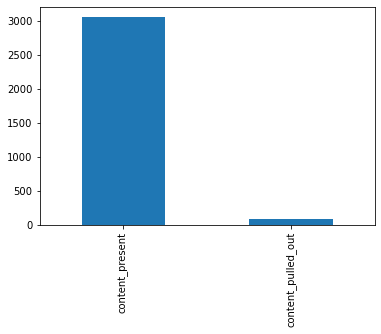

In [29]:
# Let's see the distribution

platform_content.interaction_type.value_counts(dropna=False).plot.bar()

In [30]:
# Analyzing the pulled_out articles

news_pulled=platform[platform_content.interaction_type=="content_pulled_out"]
news_pulled.shape,platform_content.shape

((74, 13), (3122, 13))

In [31]:
# Analyse the pulled_out articles in comsumers database

consumers.shape, consumers[consumers.item_id.isin(news_pulled.item_id.to_list())].shape

((50938, 8), (242, 8))

In [32]:
# drop pulled out articles from the dataframes

news=platform[platform_content.interaction_type!="content_pulled_out"]
consumers=consumers[~consumers.item_id.isin(news_pulled.item_id.to_list())]

In [33]:
# No of news articles - language-wise
news.item_type.value_counts(dropna=False)

HTML     3027
RICH       10
VIDEO      10
Name: item_type, dtype: int64

- HTML based content is very high

In [34]:
# Top 5 Producers and the No of News articles produced

news["producer_id"].value_counts(dropna=False).head()

 3609194402293569455    304
-1443636648652872475    296
-1032019229384696495    267
 3891637997717104548    131
-2979881261169775358     89
Name: producer_id, dtype: int64

- Producer 3609194402293569455 has produced more Articles

In [35]:
# Producer and item_type counts

Top3=news[["item_type","producer_id"]].value_counts(dropna=False).reset_index(). \
                        sort_values(by=["item_type",0,"producer_id"], ascending=False).groupby(by=["item_type"]).head(3)
Top3

,item_type,producer_id,0
139,VIDEO,6960073744377754728,3
206,VIDEO,6013226412048763966,1
202,VIDEO,4417246933621591943,1
167,RICH,-1130272294246983140,2
192,RICH,4340306774493623681,1
194,RICH,2062670502532932588,1
0,HTML,3609194402293569455,304
1,HTML,-1443636648652872475,296
2,HTML,-1032019229384696495,266


- Producers have produced more HTML content then Video/Rich based

In [36]:
# Articles distrbution

news["item_id"].value_counts(dropna=False).head()

-4110354420726924665    1
-5283009029345397378    1
-5850390492300666299    1
-7165716941095296287    1
-5649504870272917833    1
Name: item_id, dtype: int64

- No duplicates in item_id

In [37]:
# Producer and their articles

news[["producer_id","item_id"]].value_counts(dropna=False).head(5)

producer_id           item_id             
-9120685872592674274  -8632408281960398473    1
 3609194402293569455  -7322744040992592407    1
                      -7714713652743527644    1
                      -7666273193533605701    1
                      -7655127094029937288    1
dtype: int64

In [38]:
# No of news articles - language-wise
news.language.value_counts(dropna=False)

en    2211
pt     829
la       3
es       2
ja       2
Name: language, dtype: int64

- 2211 English articles

In [39]:
# No of news articles - Country-wise
news.producer_country.value_counts(dropna=False)

NaN    2378
BR      602
US       59
CA        5
AU        2
PT        1
Name: producer_country, dtype: int64

- Brazilian producers are more

In [40]:
news[["language","producer_country"]].value_counts(dropna=False).head()

language  producer_country
en        NaN                 1744
pt        NaN                  627
en        BR                   402
pt        BR                   200
en        US                    57
dtype: int64

- Brazilians have produced more articles in English, than the native language Portuguese

In [41]:
# Exploring producer_device_info column

news.producer_device_info.value_counts().head()

Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.116 Safari/537.36        70
Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36    64
Android - Native Mobile App                                                                                      35
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36         29
Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36        27
Name: producer_device_info, dtype: int64

- Description is too lengthy, so we will extract some important information from it.

In [42]:
# Let's explore title column
news.title.value_counts().head()

Dries Buytaert                                                                                       4
Fooling The Machine                                                                                  4
Preventing Software Bugs from Ever Occurring - Quality Functions                                     4
Adobe CQ/Adobe AEM                                                                                   3
Inside Capacitor, BigQuery's next-generation columnar storage format | Google Cloud Big Data Blog    3
Name: title, dtype: int64

- We can see duplicate Titles, with different item_id. Let's analyse further

In [43]:
# extract duplicate title items
df1=news.title.value_counts().rename_axis('unique_values').reset_index(name='cnt')
df1=news[news.title.isin(df1[df1.cnt>1].unique_values.to_list())]
dup_titles=df1.sort_values(["title","producer_id"])
dup_titles.head(3)

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
1908,1469718877,content_present,7251252752220327534,-1032019229384696495,3028199142413699225,NaN,NaN,NaN,HTML,http://thecooperreview.com/non-threatening-leadership-strategies-for-women/,9 Non-Threatening Leadership Strategies for Women,"In this fast-paced business world, female leaders need to make sure they're not perceived as pus...",en
1910,1469719009,content_present,1881534532776527237,-1032019229384696495,3028199142413699225,NaN,NaN,NaN,HTML,http://thecooperreview.com/non-threatening-leadership-strategies-for-women/,9 Non-Threatening Leadership Strategies for Women,"In this fast-paced business world, female leaders need to make sure they're not perceived as pus...",en
681,1461954566,content_present,-4187268503708157132,-1443636648652872475,-7777675406803857155,NaN,NaN,NaN,HTML,http://www.wired.com/2016/04/franz-messenger-app/,A Single App That'll Wrangle Your Millions of Messengers,"Way back in the Mesozoic Era of the Internet, which was approximately 2009, maintaining your sta...",en


In [44]:
# Analyze further text_description of these duplicate titled articles
dup_titles["textlen"]= dup_titles.text_description.str.len()
dup_titles=dup_titles.sort_values(["title","textlen","producer_id"],ascending=False)
dup_titles[["item_id","title","textlen","producer_id","item_url"]]

,item_id,title,textlen,producer_id,item_url
539,756136904399885845,You can now be identified by your 'brainprint' with 100% accuracy | KurzweilAI,4790,-2979881261169775358,http://www.kurzweilai.net/you-can-now-be-identified-by-your-brainprint-with-100-accuracy
541,1347061627677516149,You can now be identified by your 'brainprint' with 100% accuracy | KurzweilAI,4790,-2979881261169775358,http://www.kurzweilai.net/you-can-now-be-identified-by-your-brainprint-with-100-accuracy
3007,-7358932766266901263,Why Many Smart Contract Use Cases Are Simply Impossible - CoinDesk,15121,-8420584158427265596,http://www.coindesk.com/three-smart-contract-misconceptions/
3009,8550670510357310628,Why Many Smart Contract Use Cases Are Simply Impossible - CoinDesk,15121,-8420584158427265596,http://www.coindesk.com/three-smart-contract-misconceptions/
2431,7993526700719577624,What Science Tells Us About Leadership Potential,8429,6013226412048763966,https://hbr.org/2016/09/what-science-tells-us-about-leadership-potential?
...,...,...,...,...,...
1515,-8632408281960398473,Adobe CQ/Adobe AEM,1105,-9120685872592674274,http://www.wemblog.com/2014/01/how-to-include-cq-package-from-other.html
681,-4187268503708157132,A Single App That'll Wrangle Your Millions of Messengers,46754,-1443636648652872475,http://www.wired.com/2016/04/franz-messenger-app/
683,-456574518348806233,A Single App That'll Wrangle Your Millions of Messengers,46754,-1443636648652872475,http://www.wired.com/2016/04/franz-messenger-app/
1908,7251252752220327534,9 Non-Threatening Leadership Strategies for Women,2371,-1032019229384696495,http://thecooperreview.com/non-threatening-leadership-strategies-for-women/


- We can see they are purely duplicates. 

In [45]:
# Let's see if any consumer_interactions for these articles

cons=consumers[consumers.item_id.isin(dup_titles.item_id.tolist())]
cons[["item_id","consumer_id","interaction_type"]].value_counts()

item_id               consumer_id           interaction_type
-8909927294729358771  -8093344434152153830  content_watched     1
 2628816849077589497  -6933516293840979472  content_watched     1
 2468005329717107277  -1292787032977259947  content_watched     1
                      -709287718034731589   content_watched     1
                      -510621402112686165   content_watched     1
                                                               ..
-3020916840917845519   3938645257702379823  content_watched     1
                       4313424003136719348  content_watched     1
                       4316004032341334816  content_watched     1
                       5127372011815639401  content_watched     1
 9124439338148818380   3636910968448833585  content_watched     1
Length: 908, dtype: int64

- We can see many interactions for these duplicate articles, so we will need to drop duplicates that don't have any interaction only

In [46]:
# dropping articles having duplicate titles and without any consumer interaction

# List of item_ids to drop
droplist = list(set(dup_titles.item_id.unique())-set(cons.item_id.unique()))

#Dropping
news=news[~news.item_id.isin(droplist)]
print(str(len(droplist))+" articles with duplicate titles and which don't have consumer_interaction are dropped")

30 articles with duplicate titles and which don't have consumer_interaction are dropped


In [47]:
# Lets explore text_description column

news.text_description.str.len().describe()

count      3017.000000
mean       5436.348359
std        6183.242040
min         301.000000
25%        1912.000000
50%        3777.000000
75%        6776.000000
max      122568.000000
Name: text_description, dtype: float64

- Max length of text_description is 122568 and min length is 301

In [48]:
# Lets see text_description of an article

news.text_description.to_list()[0]

'All of this work is still very early. The first full public version of the Ethereum software was recently released, and the system could face some of the same technical and legal problems that have tarnished Bitcoin. Many Bitcoin advocates say Ethereum will face more security problems than Bitcoin because of the greater complexity of the software. Thus far, Ethereum has faced much less testing, and many fewer attacks, than Bitcoin. The novel design of Ethereum may also invite intense scrutiny by authorities given that potentially fraudulent contracts, like the Ponzi schemes, can be written directly into the Ethereum system. But the sophisticated capabilities of the system have made it fascinating to some executives in corporate America. IBM said last year that it was experimenting with Ethereum as a way to control real world objects in the so-called Internet of things. Microsoft has been working on several projects that make it easier to use Ethereum on its computing cloud, Azure. "Et

In [49]:
# Analyzing articles count in Conmsumers dataset

news.item_id.nunique(),consumers.item_id.nunique(),news.item_id.nunique()-consumers.item_id.nunique()

(3017, 2918, 99)

- We can see about 99 articles are not read. Probably they are new articles.


In [50]:
# lets save articles_not_watched
articles_not_watched=set(news.item_id.unique())-set(consumers.item_id.unique())
articles_not_watched=news[news.item_id.isin(list(articles_not_watched))][["item_id","title"]]
articles_not_watched.head()

,item_id,title
4,2448026894306402386,"IBM Wants to ""Evolve the Internet"" With Blockchain Technology"
6,-2148899391355011268,Banks Need To Collaborate With Bitcoin and Fintech Developers
34,3037840448416371691,Bitcoin Wallets as Swiss Bank Accounts: The Developer's Perspective
58,7973573994178035769,"Governo Dilma é desaprovado por 69% e aprovado por 10%, diz Ibope"
93,8082202054464515448,"Com HoloLens, Microsoft torna realidade a mensagem holográfica de ""Star Wars"""


## 2.0 - Data Preprocessing

In [51]:
# print shapes of datasets
consumers.shape,news.shape

((50696, 8), (3017, 13))

In [52]:
#### Devise Info is too long and let's reduce the length for better visualization

def deviseOS(txt) :
    pattern = "\((.*?)\)"
    if re.search(pattern, txt) is not None:
        return(re.search(pattern, txt).group(1)[:20] )
    else:
        return(txt[:20])

#### 2.1 Extract important Device Info

In [53]:
#### Producer Devise Info is too long and let's reduce the length for better visualization

# Filling Device Info column NaNs with "NA"
news["producer_device_info"].fillna("NA",inplace=True)
consumers["consumer_device_info"].fillna("NA",inplace=True)

# Extract important Device Info
news["producer_device_info"]=news.producer_device_info.apply(lambda x: deviseOS(x))
consumers["consumer_device_info"]=consumers.consumer_device_info.apply(lambda x: deviseOS(x))

# Lets see few values
print(consumers.consumer_device_info.value_counts(dropna=False).head(5))
news.producer_device_info.value_counts(dropna=False).head(5)

NA                      11049
Macintosh; Intel Mac     9552
X11; Linux x86_64        8470
Windows NT 10.0; WOW     6902
Android - Native Mob     3977
Name: consumer_device_info, dtype: int64


NA                      2351
Macintosh; Intel Mac     201
X11; Linux x86_64        192
Windows NT 10.0; WOW     136
Windows NT 10.0; Win      65
Name: producer_device_info, dtype: int64

- Most of the devices info is not available.
- From the avaiable data, Windows NT 10 based devises have been used to read & Produce the articles the most

#### 2.2 Converting Interaction_type into Ratings values

In [54]:
# Create the dictionary of Topic names and Topics

ratings = {"content_followed" :5, "content_commented_on" :4, "content_saved" :3, "content_liked" :2, "content_watched" :1}

# Apply rating based on the interaction_type
consumers['ratings'] = consumers.interaction_type.apply(lambda x: ratings.get(x))

# We will drop interaction_type

#### 2.3 Missing value Treatment

In [55]:
# Finding the missing values (column-wise)
consumers.isnull().mean().round(3)*100

event_timestamp          0.0
interaction_type         0.0
item_id                  0.0
consumer_id              0.0
consumer_session_id      0.0
consumer_device_info     0.0
consumer_location       21.8
country                 21.8
ratings                  0.0
dtype: float64

In [56]:
# Finding the missing values (column-wise)
news.isnull().mean().round(3)*100

event_timestamp          0.0
interaction_type         0.0
item_id                  0.0
producer_id              0.0
producer_session_id      0.0
producer_device_info     0.0
producer_location       77.9
producer_country        77.9
item_type                0.0
item_url                 0.0
title                    0.0
text_description         0.0
language                 0.0
dtype: float64

- We can see that there are high % of Missing values, which needs to be treated. However, Since we need them only for the visualization, we will just fill all NaNs with "NotAvailable" tag

In [57]:
# Let's fill Missing values with "NotAvailable"

consumers.fillna("NotAvailable",axis=1,inplace=True)
news.fillna("NotAvailable",axis=1,inplace=True)

#### 2.4 Data type Conversion

In [58]:
# Converting item_id and consumer_id into char type for better visualization
consumers.consumer_id= consumers.consumer_id.astype('str')
consumers.item_id= consumers.item_id.astype('str')
consumers.ratings= consumers.ratings.astype('int64')

news.producer_id= news.producer_id.astype('str')
news.item_id= news.item_id.astype('str')

# let's check the final consumers dataframe
print(consumers.info())
print(news.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50696 entries, 0 to 72311
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       50696 non-null  object
 1   interaction_type      50696 non-null  object
 2   item_id               50696 non-null  object
 3   consumer_id           50696 non-null  object
 4   consumer_session_id   50696 non-null  object
 5   consumer_device_info  50696 non-null  object
 6   consumer_location     50696 non-null  object
 7   country               50696 non-null  object
 8   ratings               50696 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 3.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3017 entries, 1 to 3121
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       3017 non-null   object
 1   interaction_type      301

## 3 Visualization of Consumers & Platform Datasets

### 3.1 Visualizing the Consumers features

In [59]:
# Let's define a standard plotting function to use for our variables

def Plotting(df, col1, col2, Graph):

    # Find and Filter the dataframe for Top 10 values, if values are more
    df1=df[col1].value_counts().rename_axis('unique_values').reset_index(name='cnt')
    if len(df1) > 10 :
        df=df[df[col1].isin(df1[:10].unique_values.to_list())]
                          
    # Define sub-plots and the size
    plt.figure(figsize=(22,6))
    plt.subplots_adjust(hspace = 1)

    #  Plotting Column Value Counts - Pie Plot
    ax0=plt.subplot(1,3,1)
    
    # Let's set the position of the chart
    ax0.set_anchor('C')
    pos1 = ax0.get_position()
    pos2 = [pos1.x0, pos1.y0-0.23,  pos1.width, pos1.height+0.25]
    ax0.set_position(pos2)
    
    # Define labels rotation
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    if Graph in ["P","N"] :
        titl='Sub-Categories of : '+ col1
        df[col1].value_counts().plot.pie(autopct = "%1.0f%%", radius=1.0)
        
    plt.title(titl,fontdict={'fontsize': 15, 'fontweight' : 5, 'color' : 'Purple'})
         
    #  Distribution of Column Values
    ax1=plt.subplot(1,3,2)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    ax0.tick_params(axis="x", labelsize=10, labelrotation=45, labelcolor="turquoise")
    ax0.tick_params(axis="y", labelsize=10, labelrotation=45, labelcolor="orange")
    if Graph in ["P","N"] :
        titl= "Distribution of " + col1 
        sns.countplot(y= col1, data = df )
    plt.title(titl,fontdict={'fontsize': 15, 'fontweight' : 5, 'color' : 'Purple'})
        
    #  Distribution of Column Values against rating
    ax2=plt.subplot(1,3,3)
    
    if Graph == "P" :
        titl= "Distribution of " + col1 +" againt "+ col2
        sns.countplot(y=col1, hue=col2, data=df)
    else :
        titl= "Distribution of " + col1 
        sns.distplot(df[col1])
    plt.title(titl,fontdict={'fontsize': 15, 'fontweight' : 5, 'color' : 'Purple'})
    plt.tight_layout() 
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    plt.show()

In [60]:
CategoricalCols = list(set(consumers.columns)-set(consumers.describe().columns))
CategoricalCols
consumers.sample(2)

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country,ratings
47071,1472479389,content_watched,-2584174137395076448,692689608292948411,1759398373487699463,Windows NT 10.0; Win,SP,BR,1
57143,1476463554,content_watched,1059874396577697902,-4309872815953358011,2329988608871311555,Android - Native Mob,SP,BR,1


In [61]:
consumers.describe().columns

Index(['ratings'], dtype='object')

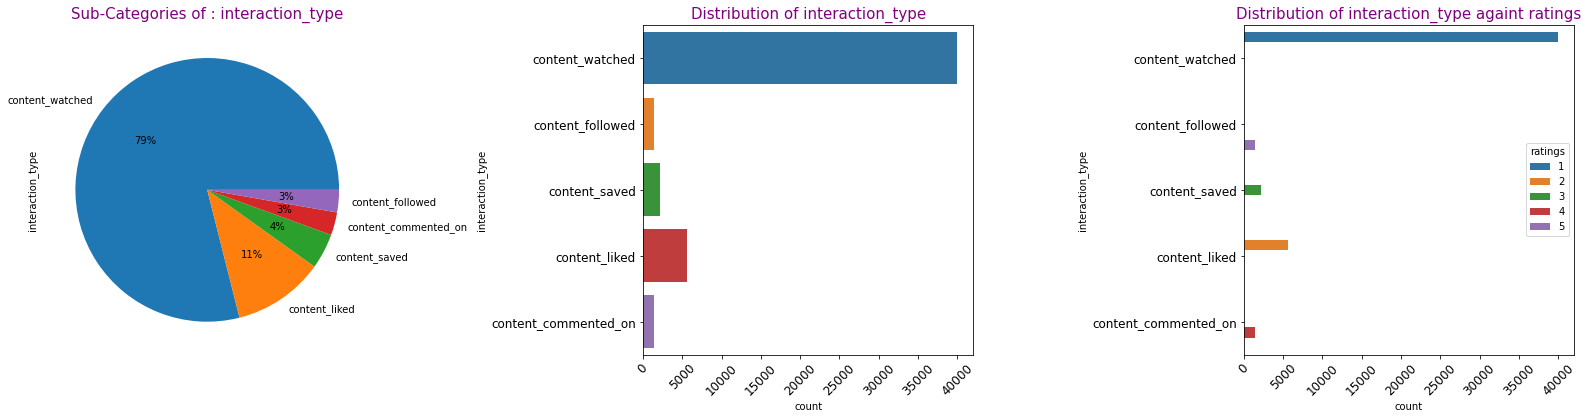

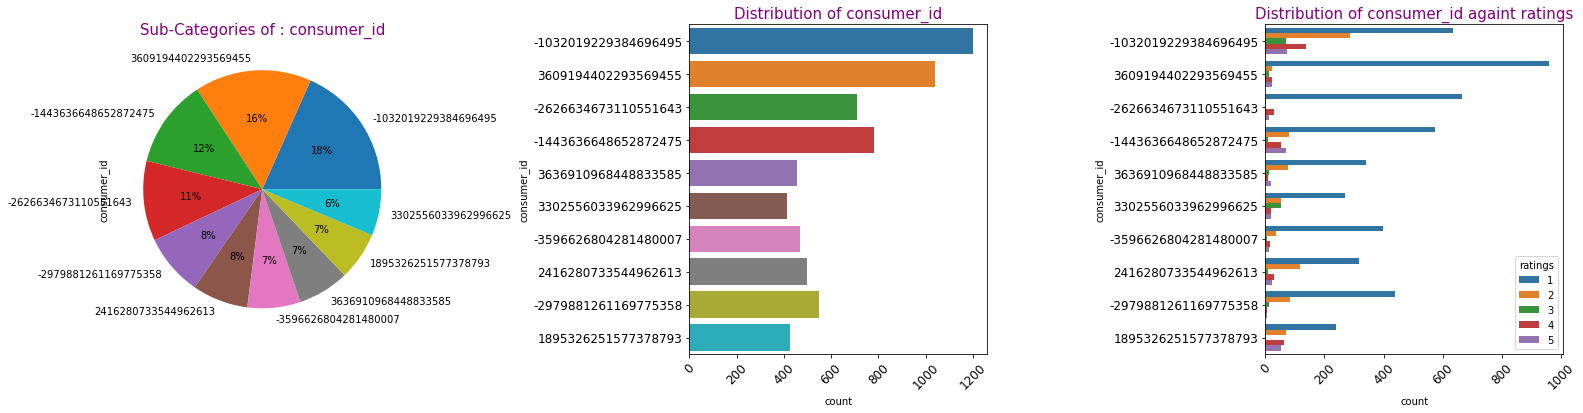

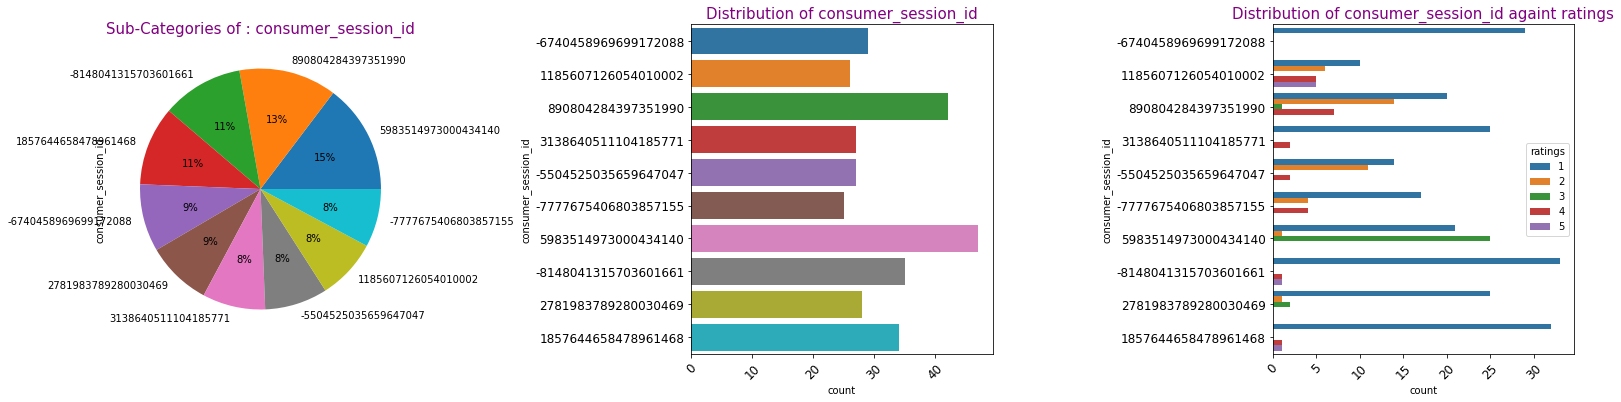

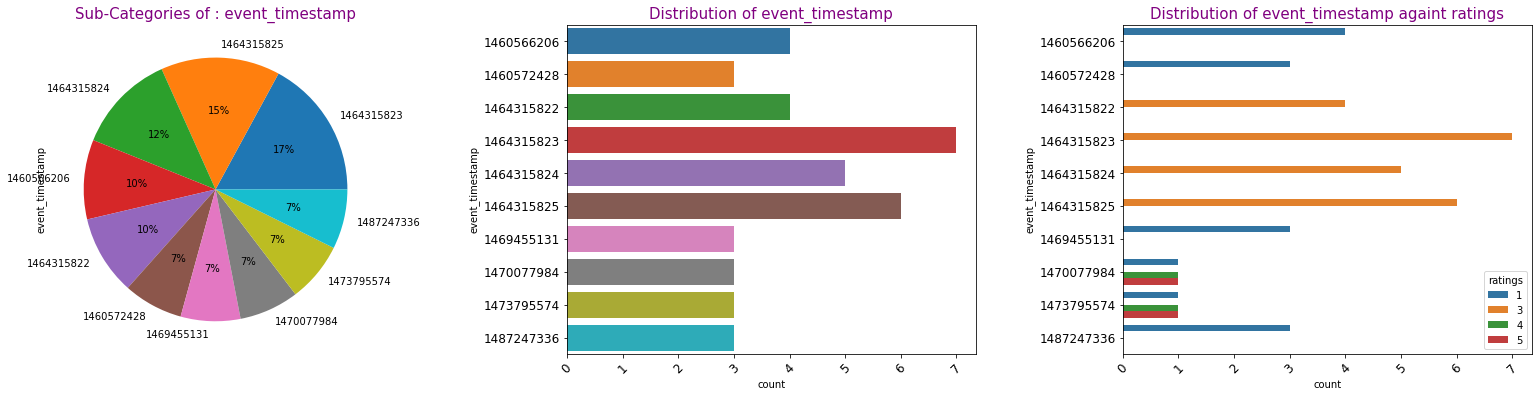

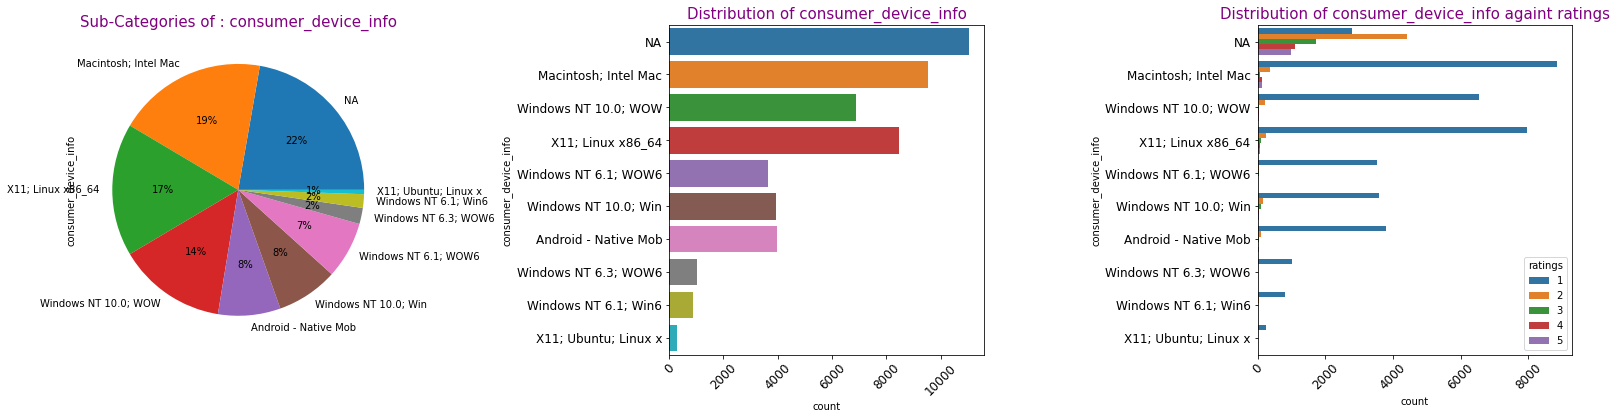

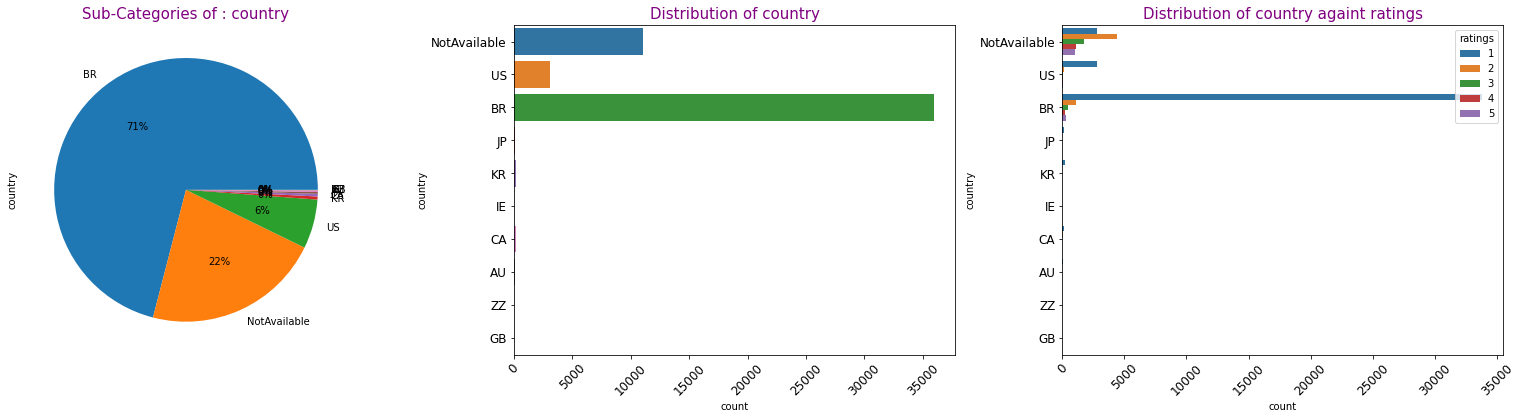

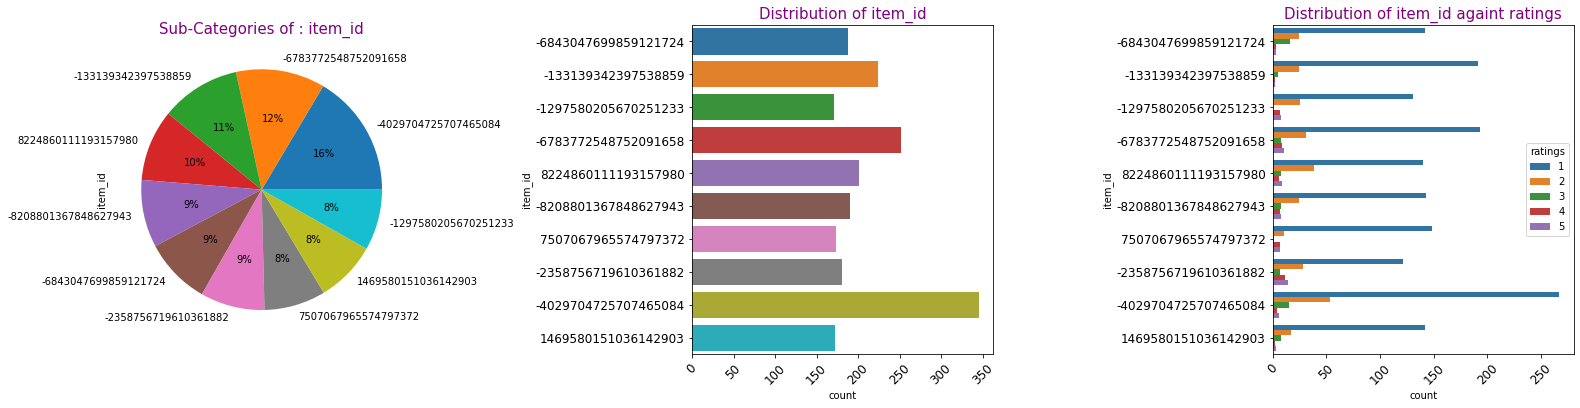

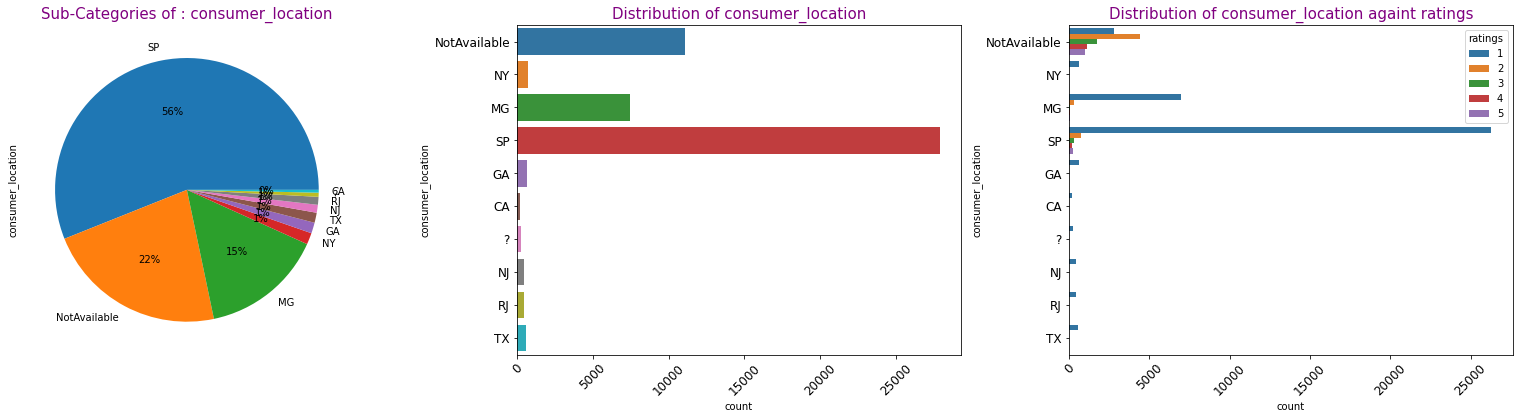

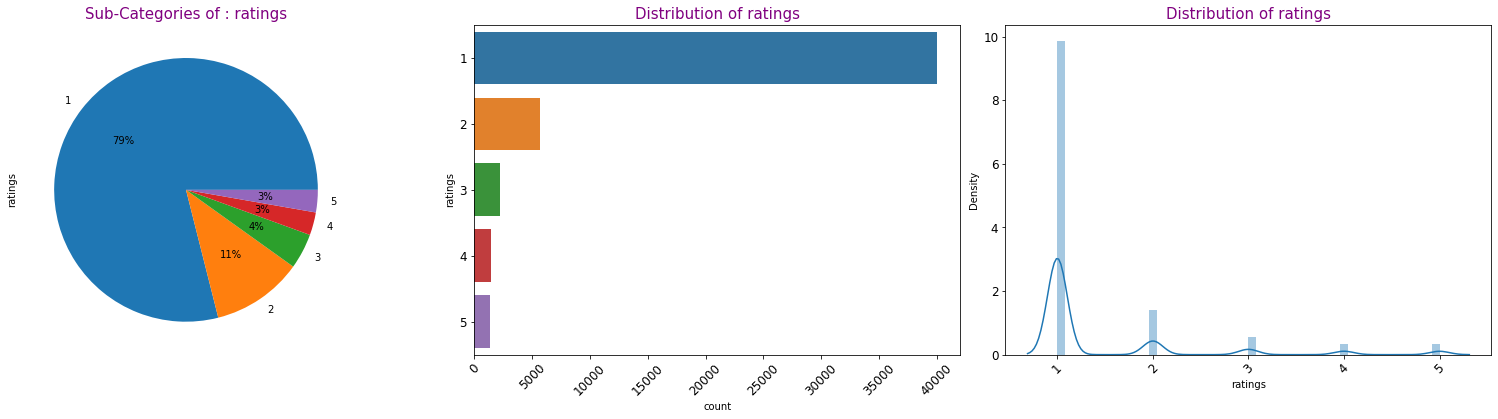

In [62]:
# Plotting for Categorical & Numerical columns in consumers database

CategoricalCols = list(set(consumers.columns)-set(consumers.describe().columns))
NumericalCols = consumers.describe().columns

for col in CategoricalCols :
    Plotting(consumers,col,"ratings","P")

for col in NumericalCols :
    Plotting(consumers,col,"ratings","N")
    

### 3.2 Visualizing the Platform Content features

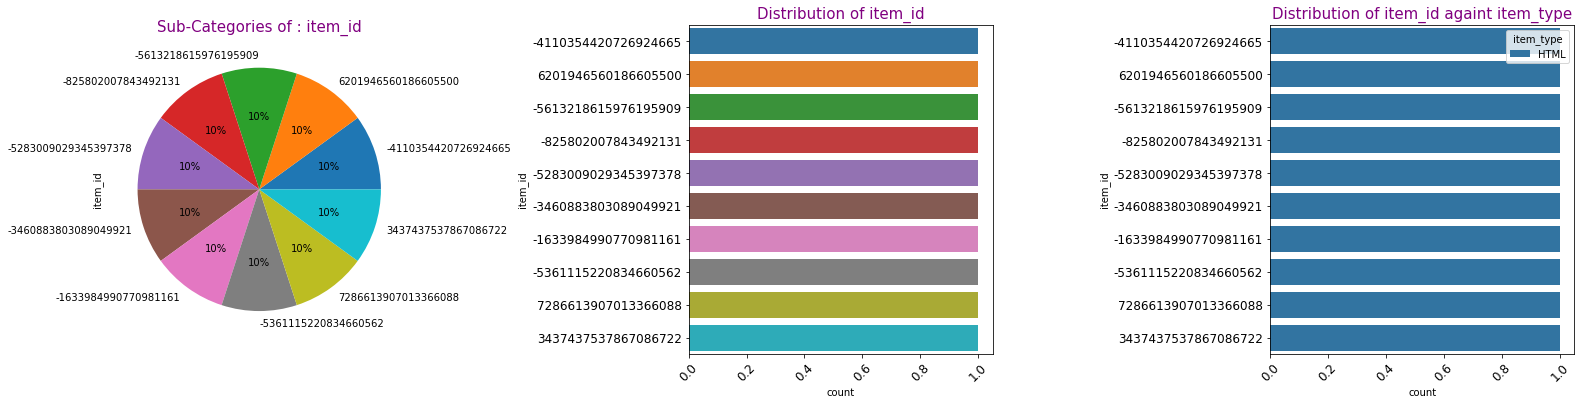

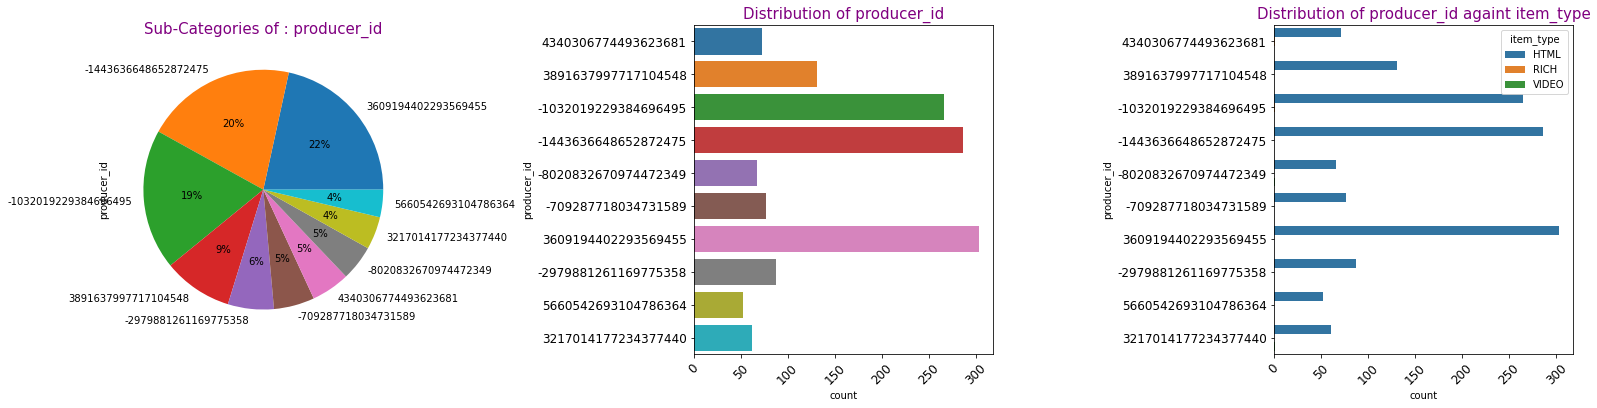

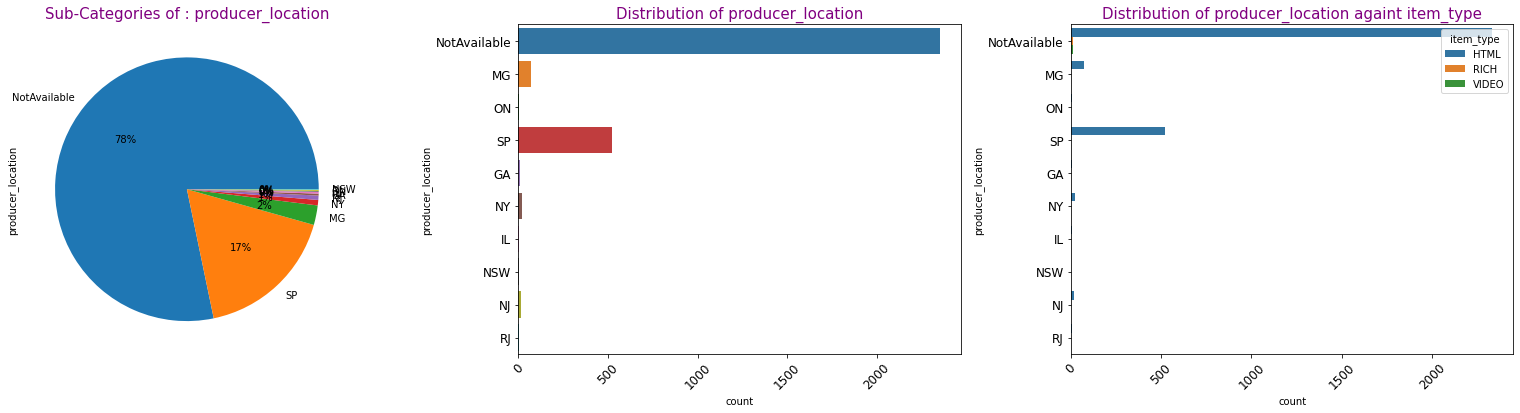

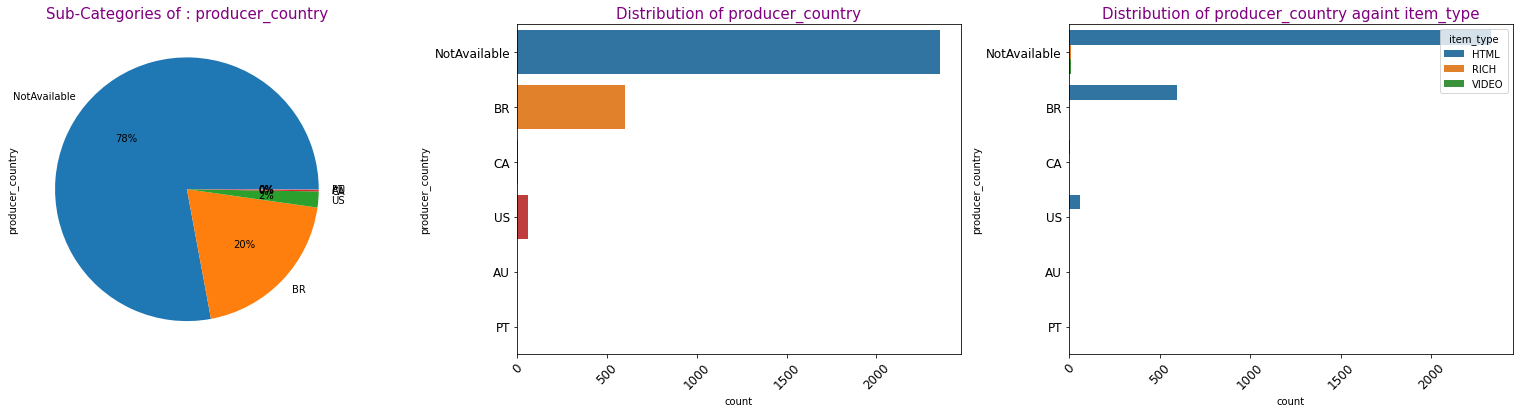

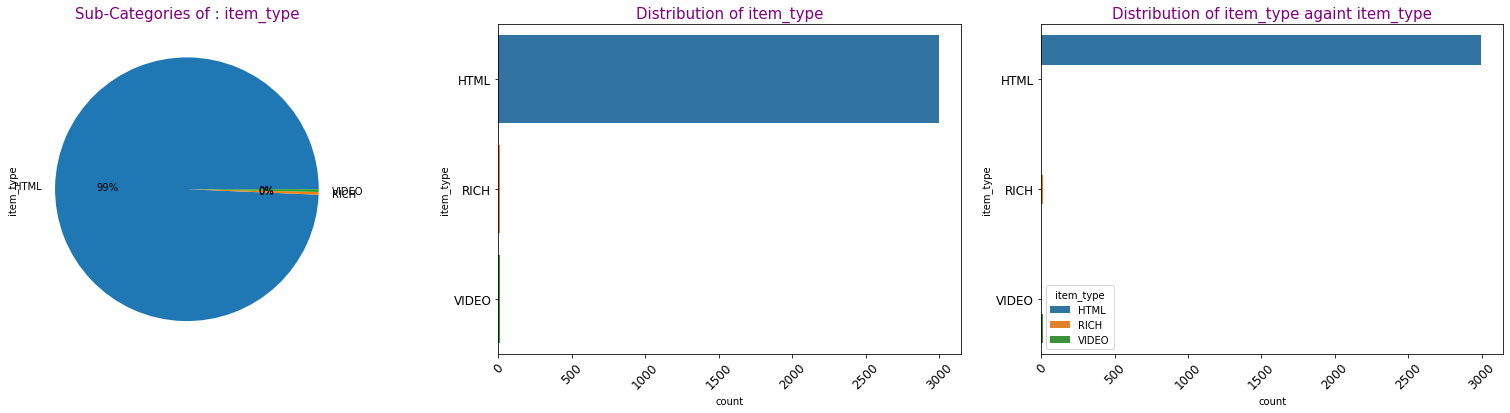

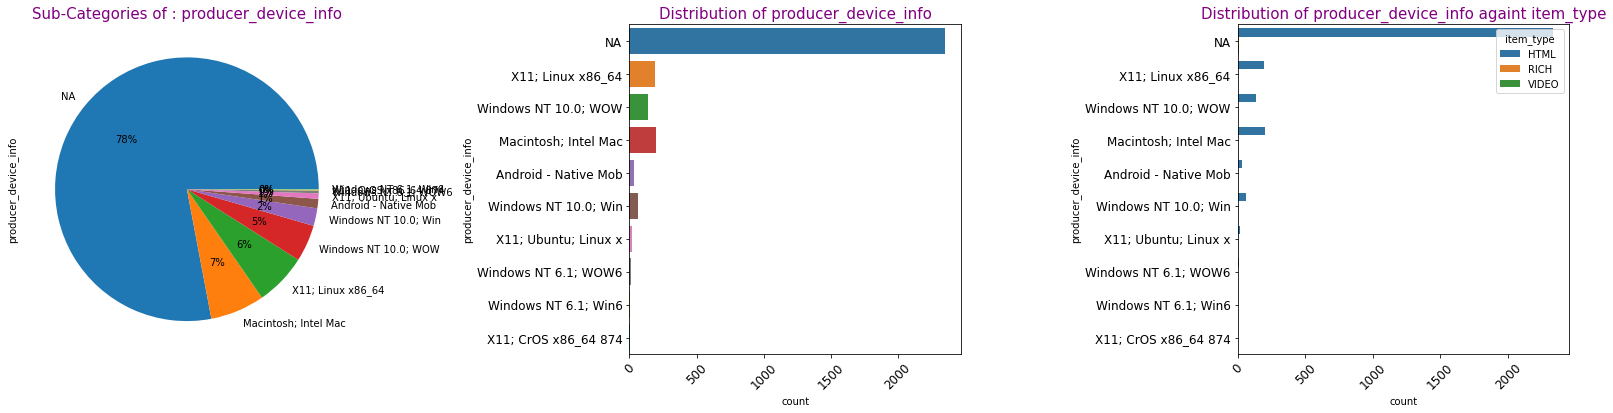

In [63]:
# Plotting for Categorical & Numerical columns
# Let's exclude features title, text_description, as it won't give any insight

CategoricalCols = ['item_id', 'producer_id', 'producer_location','producer_country', 'item_type','producer_device_info'] 

NumericalCols = []

for col in CategoricalCols :
    Plotting(news,col,"item_type","P")

for col in NumericalCols :
    Plotting(news,col,"item_type","N")

### 4 Data manipulation

#### 4.1 Extracting English Articles from News & consumers data frame

In [65]:
# Let's remove non-english news
news_not_en=news[news.language != "en"]
news =news[news.language == "en"]
consumers=consumers[~consumers.item_id.isin(news_not_en.item_id.to_list())]

#### 4.2 Dropping unnecessary columns

In [66]:
#let's drop columns which have no signifcance

consumers.drop(["event_timestamp","consumer_session_id","consumer_device_info","interaction_type"],axis=1,inplace=True)
news.drop(["event_timestamp","producer_session_id","producer_device_info","item_url","language"],axis=1,inplace=True)

#### 4.3 Finalizing ratings given by Consumer against each Article


In [67]:
# Creating consumer_interactions dataset with final ratings to process various models

consumer_interactions = consumers[["consumer_id","item_id","ratings"]]
consumer_interactions = consumer_interactions.sort_values(by=["consumer_id","item_id","ratings"],ascending=True)
consumer_interactions = consumer_interactions.drop_duplicates(subset=["consumer_id","item_id"],keep="last")
consumer_interactions.shape

(40486, 3)

#### 4.4 Converting item_id and consumer_id from Normalized form to real Index No i.e item_id_n, consumer_id_n

In [68]:
# Converting item_ids from normalized form to real index no

articles = pd.DataFrame(consumers.item_id.unique())

# Merge articles that are not watched
articles= pd.concat([articles,articles_not_watched["item_id"]])

# Reset the index
articles.reset_index(inplace=True)

# Assign Column Names
articles.columns=["item_id_n","item_id"]

# Create the new index Column 
articles.item_id_n=articles.item_id_n+1

# Merge with News dataframe to get the Titles
newsitems= pd.merge(articles, news[['item_id', 'title']], on='item_id', how='left')
# Drop null Titles, if any
newsitems = newsitems[newsitems.title.notnull()]


# Converting consumer_ids

# Get Unique Consumers 
consumerIDs = pd.DataFrame(consumers.consumer_id.unique())
# Reset teh index
consumerIDs.reset_index(inplace=True)
#Rename columns
consumerIDs.columns=["consumer_id_n","consumer_id"]
# Create new Consumer ID
consumerIDs.consumer_id_n=consumerIDs.consumer_id_n+1

In [69]:
# Assigning above new columns consumer_id_n, item_id_n in consumer_interactions & newsitems datasets

# Create new empty columns with nulls
newsitems["item_id_n"]=np.nan
consumer_interactions["item_id_n"]=np.nan
consumer_interactions["consumer_id_n"]=np.nan

# Assign new consumer ID to all consumers
for index, row in consumerIDs.iterrows() :
    consumer_interactions.loc[consumer_interactions.consumer_id==row.consumer_id, "consumer_id_n"]=row.consumer_id_n

# Assign new item ID to all items in consumers and news items dataframes
for index, row in articles.iterrows() :
    consumer_interactions.loc[consumer_interactions.item_id==row.item_id, "item_id_n"]=row.item_id_n
    newsitems.loc[newsitems.item_id==row.item_id, "item_id_n"]=row.item_id_n

# Convert dtype of new columns to to Intergers
consumer_interactions.consumer_id_n= consumer_interactions.consumer_id_n.astype('int64')
consumer_interactions.item_id_n= consumer_interactions.item_id_n.astype('int64')
newsitems.item_id_n= newsitems.item_id_n.astype('int64')


#### 4.5 Final inspection of consumers_interaction dataset being used for the modelling

In [70]:
# Shapes of final Dataframes

consumers.shape,news.shape

((50696, 5), (2188, 8))

In [71]:
# Sample data

consumer_interactions.sample(5)

,consumer_id,item_id,ratings,item_id_n,consumer_id_n
30413,-3696538850054062306,2727743992157210358,1,1548,1026
69206,1560134519462672730,991271693336573226,1,2795,96
58164,-4585796377251906117,-2217888411555964341,1,1956,23
41890,-6067316262393890508,-7862677531530632089,1,1317,237
45127,-6149164633108566454,3616722904601574426,1,1976,610


#### 4.6 Finding default values to use in various models

In [72]:
# Finding Idividual Consumers & News Counts being used in the models

consumers_count = consumer_interactions.consumer_id_n.nunique()
articles_count = consumer_interactions.item_id_n.nunique()
consumers_count,articles_count

(1894, 2918)

In [73]:
# No of articles to recommend

k=10

# As per the definition of ‘interaction type’, the content liked can be considered as the Threshold Rating
threshold_rating = 2

# Find the consumer who watched highest articles - i.e sample_consumer
sample_consumer=consumer_interactions[consumer_interactions.ratings >= threshold_rating]. \
                                      consumer_id_n.value_counts()[:1].reset_index()["index"].iloc[0]

# Find the article which was watched by many consumers - i.e sample_article
sample_article=consumer_interactions.item_id_n.value_counts()[:1].reset_index()["index"].iloc[0]
sample_title = newsitems.loc[newsitems.item_id_n==sample_article]["title"].iloc[0]

print("Sample_consumer = ",sample_consumer, " sample_article = ",sample_article, " title = ",sample_title)

Sample_consumer =  2  sample_article =  2864  title =  Former Google career coach shares a visual trick for figuring out what to do with your life


## 5 Content Based Recommendation Model

### 5.1 Preparing Dataset for the BOW Dictionary

In [74]:
# Create a new Dataframe with item_id, title, text_description 
news_text = pd.merge(newsitems,news[['item_id','text_description']],on='item_id', how='left')
# Drop null Titles, if any
news_text = news_text[news_text.title.notnull()]

# Print shape
news_text.shape


(2106, 4)

In [75]:
# Top rows

news_text.head()

,item_id_n,item_id,title,text_description
0,1,-3499919498720038879,Hiri wants to fix the workplace email problem,"Hiri is the latest startup trying to fix email. Specifically, the Dublin-based company is target..."
1,2,8890720798209849691,Top 10 Intranet Trends of 2016,"Summary: Hero images, carousels, fat footers, video, minimalist design, and responsive navigatio..."
2,4,-7820640624231356730,How This Googler Redesigned The Workweek,Jake Knapp has always been concerned about the speed at which time passes. Even back in his coll...
3,6,-1492913151930215984,Chrome DevTools - Console API Reference,The DevTools docs have moved! Read the latest version of this article and head over to the new h...
4,7,3064370296170038610,"Google, Amazon and the upcoming battle over AI Assistants","The stage is set for the coming battle between the big five tech giants: Google, Apple, Facebook..."


In [76]:
#df['c'] = df.apply(lambda row: row.a + row.b, axis=1)
news_text['itemid_title']=news_text.apply(lambda row: str(row.item_id_n).rjust(len(str(news_text.shape[0])),'0')+row.title, axis=1)
news_text.head()

,item_id_n,item_id,title,text_description,itemid_title
0,1,-3499919498720038879,Hiri wants to fix the workplace email problem,"Hiri is the latest startup trying to fix email. Specifically, the Dublin-based company is target...",0001Hiri wants to fix the workplace email problem
1,2,8890720798209849691,Top 10 Intranet Trends of 2016,"Summary: Hero images, carousels, fat footers, video, minimalist design, and responsive navigatio...",0002Top 10 Intranet Trends of 2016
2,4,-7820640624231356730,How This Googler Redesigned The Workweek,Jake Knapp has always been concerned about the speed at which time passes. Even back in his coll...,0004How This Googler Redesigned The Workweek
3,6,-1492913151930215984,Chrome DevTools - Console API Reference,The DevTools docs have moved! Read the latest version of this article and head over to the new h...,0006Chrome DevTools - Console API Reference
4,7,3064370296170038610,"Google, Amazon and the upcoming battle over AI Assistants","The stage is set for the coming battle between the big five tech giants: Google, Apple, Facebook...","0007Google, Amazon and the upcoming battle over AI Assistants"


In [77]:
# min and max lengths of the Text_description

news_text['text_description'].str.len().min(), news_text['text_description'].str.len().max()

(301, 122568)

In [78]:
# convert to numpy arrays

news_text_array = news_text['text_description'].to_numpy()
news_text_array

array(["Hiri is the latest startup trying to fix email. Specifically, the Dublin-based company is targeting workplace email with an array of features that aim to nudge users to change their email behaviour for the better. For it isn't email that is necessarily broken but the way we all use and abuse it. Starting with the premise that thoughtless and un-targeted emails fill a very high percentage of your work email inbox, Hiri's headline feature is the ability for recipients to rate each email they receive, which serves as the basis for your own email score or email analytics. You've given a weekly score based on feedback received relating to clarity, brevity, and tone, and the software's rating of your overall email behaviour. The idea, the startup's CEO and co-founder Kevin Kavanagh told me during a call last week, is to get employees thinking about how they currently use email and to begin to change their behaviour for the better. The weekly score also ensures employees don't return 

In [79]:
# Sample Text

news_text_array[0]

"Hiri is the latest startup trying to fix email. Specifically, the Dublin-based company is targeting workplace email with an array of features that aim to nudge users to change their email behaviour for the better. For it isn't email that is necessarily broken but the way we all use and abuse it. Starting with the premise that thoughtless and un-targeted emails fill a very high percentage of your work email inbox, Hiri's headline feature is the ability for recipients to rate each email they receive, which serves as the basis for your own email score or email analytics. You've given a weekly score based on feedback received relating to clarity, brevity, and tone, and the software's rating of your overall email behaviour. The idea, the startup's CEO and co-founder Kevin Kavanagh told me during a call last week, is to get employees thinking about how they currently use email and to begin to change their behaviour for the better. The weekly score also ensures employees don't return to bad 

In [80]:
# Split keywords & create the word list

news_words_list = []
for keyword in news_text_array:
    keyword = re.sub(r'[^\w\s]', "",str(keyword).lower()) # Remove punctuations
    keyword = re.sub(r'\w*\d\w*',"",keyword) # remove words containing numbers
    splitted_words = keyword.split() # Splitting the text into tokens
    splitted_words = list(set(splitted_words) - set(stopwords.words("english"))) # Remove stop words
    news_words_list.append(splitted_words)

# Top 10 words for sample 1
news_words_list[1][:10]

['welldesigned',
 'stored',
 'simplicity',
 'hires',
 'folksiness',
 'leaders',
 'stand',
 'wide',
 'see',
 'accordion']

# print the lengths of the array, sample array and words of the sampl
len(news_words_list), len(news_words_list[0]), len(news_words_list[1])

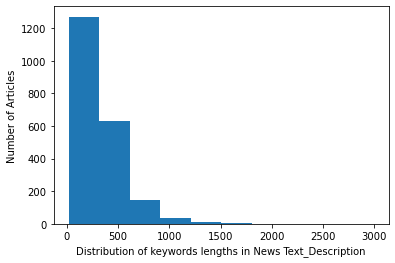

In [81]:
# Plotting Histogram of keywords lengths
number_of_keywords = []
for item in news_words_list:
    n_keywords = len(item)
    number_of_keywords.append(n_keywords)

plt.hist(number_of_keywords)
plt.xlabel('Distribution of keywords lengths in News Text_Description')
plt.ylabel('Number of Articles')
plt.show()

### 5.2 Calculating Similar News Matrix based on the TFIDF scores

In [82]:
# Create Dictionary, BOW, tfidf model & Similarity Matrix

# create a dictionary from words list
dictionary = Dictionary(news_words_list) 

#create corpus where the corpus is a bag of words for each document
corpus = [dictionary.doc2bow(doc) for doc in news_words_list] 

#create tfidf model of the corpus
tfidf = TfidfModel(corpus) 

# Create the similarity matrix.
similar_news = MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))
similar_news

### 5.3 Recommending Articles

#### 5.3.1 Recommending News similar to a sample item

In [83]:
# Creating a function which Runs the Model & return Recommended News articles
def news_recommended(news_id):
    # get the news row
    item = news_text.loc[news_text.item_id_n==news_id] 
    
    #split the keywords to query_doc
    query_doc = item['text_description'].iloc[0].split() 
    
    # get a bag of words from the query_doc
    query_doc_bow = dictionary.doc2bow(query_doc) 

    #convert the regular bag of words model to a tf-idf model
    query_doc_tfidf = tfidf[query_doc_bow] 

    #Convert to a Dataframe
    similar_articles = pd.DataFrame(similar_news[query_doc_tfidf].tolist(),index=news_text.item_id_n.values).reset_index()
    # Assign column names
    similar_articles.columns=["item_id_n","score"]
    
    # Get the Title
    similar_output = pd.merge(news_text, similar_articles,  on='item_id_n', how='left')
    # Remove null Titles
    similar_output =similar_output[similar_output.title.notnull()]

    # Remove sample_item
    similar_output = similar_output[similar_output.item_id_n != sample_article]

    #get the most similar News Articles 
    similar_output = similar_output.sort_values(["score"],ascending=False)
    # Final Dataframe
    similar_output=similar_output[["item_id_n","item_id","title","score"]]
    
    return (similar_output)

In [84]:
# Get News predicts for a sample article 

content_predicts = news_recommended(sample_article)
print(sample_title)
content_predicts[["item_id","title","score"]][1:k+1]

Former Google career coach shares a visual trick for figuring out what to do with your life


,item_id,title,score
1854,6999813113145211708,Write Like You Talk,0.068101
1591,7077639154797499584,[Tools] XMind Plus - Last Chance for students' 1$ gift,0.063742
537,3761187656635209729,How to write a hypothesis,0.063661
1150,-2476100034099959458,[Retro] Celebration Grids - Management 3.0,0.062126
1334,7526364197140419661,Digital Health Coaching,0.060133
1638,6664082205633624486,Building a Team from the Inside Out: Alok Gupta on the Evolution of Data Science at Airbnb,0.059131
1958,8659918766210334195,5 Latin Trends for 2017 | TrendWatching,0.058901
1626,7104734618727920421,Kelso's Corner,0.058456
157,8586403905004879205,How to augment your career with leadership coaching,0.058093
1669,7510090557616166004,Don't Waste Your Time on Networking Events,0.056309


#### 5.3.2 Recommending similar articles based on the Normalized scores

In [85]:
# Converting the Content score to the Min Max Normalized score

content_predicts['content_score_normalized'] = (content_predicts['score']-min(content_predicts['score'])) \
                                        / (max(content_predicts['score']) - min(content_predicts['score']))

# Sort rows based on the Normalized score
content_predicts=content_predicts.sort_values(["content_score_normalized"],ascending=False)

#Print top k News based on teh Content Filtering Model
content_predicts[["item_id","title"]].head(k)

,item_id,title
1122,7488370990373644128,This motorized wheel adds electric power to your bike
1854,6999813113145211708,Write Like You Talk
1591,7077639154797499584,[Tools] XMind Plus - Last Chance for students' 1$ gift
537,3761187656635209729,How to write a hypothesis
1150,-2476100034099959458,[Retro] Celebration Grids - Management 3.0
1334,7526364197140419661,Digital Health Coaching
1638,6664082205633624486,Building a Team from the Inside Out: Alok Gupta on the Evolution of Data Science at Airbnb
1958,8659918766210334195,5 Latin Trends for 2017 | TrendWatching
1626,7104734618727920421,Kelso's Corner
157,8586403905004879205,How to augment your career with leadership coaching


## 6 Alternating Least Square(ALS) Model

### 6.1 Creating Sparse User-Item Matrix

In [86]:
# Define Alpha and length of the consumers database
alpha = 40
consumer_interactions.shape[0]

40486

In [87]:
# creating csr matrix and fill with Ratings

sparse_user_item_mx = csr_matrix((consumer_interactions.ratings, (consumer_interactions['consumer_id_n'], \
                                                                  consumer_interactions['item_id_n'])))
sparse_user_item_mx.shape

(1895, 2919)

In [88]:
# Print the array
csr_user_array=sparse_user_item_mx.toarray()
print(csr_user_array)

[[0 0 0 ... 0 0 0]
 [0 1 3 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [89]:
# Print lengths of array, array element, rating
len(csr_user_array), len(csr_user_array[0]), csr_user_array[1][1]

(1895, 2919, 1)

In [90]:
## Min and Max values of User array
min(csr_user_array[1]),max(csr_user_array[1])

(0, 5)

### 6.2 Creating Sparse Item-User Matrix

In [91]:
### Create item-user sparse matrix

sparse_item_user_mx = sparse_user_item_mx.T.tocsr()
sparse_item_user_mx.shape

(2919, 1895)

In [92]:
# Print the item array
csr_item_array = sparse_item_user_mx.toarray()
print(csr_item_array)

[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 3 5 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [93]:
# Print lengths of the Item array, element and a sample 
len(csr_item_array), len(csr_item_array[0]), csr_item_array[1][1]

(2919, 1895, 1)

In [94]:
##  Create train, test of item_user sparse matrix
item_user_train, item_user_test = train_test_split(sparse_item_user_mx, train_percentage=0.8,random_state=21)

# Print shapes of Test & Train datasets
item_user_train.shape, item_user_test.shape

((2919, 1895), (2919, 1895))

### 6.3 Building and Training the ALS Model

In [95]:
## Building ALS Model
alsmodel = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.1, iterations=20, \
                                                calculate_training_loss=False, random_state = 21)
# Train the ALS Model
alsmodel.fit(item_user_train)

  0%|          | 0/20 [00:00<?, ?it/s]

### 6.4 Recommending Articles

### 6.4.1 Recommending Articles for a sample consumer

In [96]:
## Generating recommendations for a sample consumer

als_consumer_predicts = alsmodel.recommend(sample_consumer, item_user_test,N=item_user_test.shape[0])
# Convert to the Dataframe
als_consumer_predicts = pd.DataFrame(als_consumer_predicts, columns=['item_id_n', 'als_score'])
# Assign proper column names
als_consumer_predicts = als_consumer_predicts.sort_values("als_score",ascending=False)

#Print top rows
als_consumer_predicts.head()

,item_id_n,als_score
0,1475,1.119411
1,1937,1.099109
2,2259,1.095376
3,1242,1.092221
4,2456,1.073239


In [97]:
# Merge recommendation output with Articles Data
als_consumer_predicts = pd.merge(als_consumer_predicts[["item_id_n","als_score"]], newsitems, how='left', on='item_id_n')
# Drop rows where title is null
als_consumer_predicts = als_consumer_predicts[als_consumer_predicts.title.notnull()]

# Print top rows
als_consumer_predicts.head()

,item_id_n,als_score,item_id,title
0,1475,1.119411,-5798690764728257756,Airbnb bets on local with user-generated guidebooks and new neighborhood/home matching
1,1937,1.099109,-2479936301516183562,"GitLab launches Issue Boards, an open-source task management tool that resembles Trello"
2,2259,1.095376,-5154395767417065070,Innovation is in all the wrong places
3,1242,1.092221,4419562057180692966,Latin America's chronic inefficiency could drive more O2O commerce growth
4,2456,1.073239,1649752043999819668,Four Node.js Gotchas that Operations Teams Should Know about - The New Stack


#### 6.4.2 Recommending Simialr Articles

In [98]:
## Generating recommendations for a sample_article 2015

als_item_predicts = alsmodel.similar_items(sample_article, item_user_test.shape[0])

#Convert to the Dataframe
als_item_predicts = pd.DataFrame(als_item_predicts, columns=['item_id_n', 'score'])

# Remove sample_item
als_item_predicts = als_item_predicts[als_item_predicts.item_id_n != sample_article]

# Print top rows
als_item_predicts.head()

,item_id_n,score
1,977,0.459195
2,445,0.316466
3,2663,0.308517
4,75,0.305498
5,1464,0.300527


#### 6.4.3 Recommending Articles based on the Normalized scores

In [99]:
# Min Max Normalization

als_item_predicts['als_score_normalized'] = (als_item_predicts['score']-min(als_item_predicts['score'])) \
                                        / (max(als_item_predicts['score']) - min(als_item_predicts['score']))
# Sort based on Normalized scores
als_item_predicts=als_item_predicts.sort_values(["als_score_normalized"],ascending=False)

# Merge with newsitems for Title
als_item_predicts = pd.merge(als_item_predicts, newsitems, how='left', on='item_id_n')

# Drop null Titles, if any
als_item_predicts = als_item_predicts[als_item_predicts.title.notnull()]

# Top 5 rows
als_item_predicts.head()

,item_id_n,score,als_score_normalized,item_id,title
0,977,0.459195,1.000000,-2151750849426701342,NES classic 'Punch-Out' has an Easter egg that went undiscovered for 29 years
2,2663,0.308517,0.727988,-1324705355456975418,4 essential how-tos for dealing with scope creep
4,1464,0.300527,0.713565,-8368414190009234878,[Course] Gamification - University of Pennsylvania | Coursera
6,1416,0.281595,0.679387,-4570752586662989981,End is nigh for Rosetta
8,1160,0.250321,0.622930,9136323715291453594,How to Improve 8 Major Problem Areas for Japanese Learners of All Levels


In [100]:
# Final Top k Similar Items

als_item_predicts[["item_id",'title']].head(k)

,item_id,title
0,-2151750849426701342,NES classic 'Punch-Out' has an Easter egg that went undiscovered for 29 years
2,-1324705355456975418,4 essential how-tos for dealing with scope creep
4,-8368414190009234878,[Course] Gamification - University of Pennsylvania | Coursera
6,-4570752586662989981,End is nigh for Rosetta
8,9136323715291453594,How to Improve 8 Major Problem Areas for Japanese Learners of All Levels
11,-4158297476631283435,"[Situation Wall] Jamboard - the whiteboard, reimagined for collaboration in the cloud"
12,4402253552023115142,Introduction to Guitar - Berklee | Coursera
13,1423541364223434892,Saving the World Through Crypto: The Humanitarian Blockchain
14,3720742491238027703,29 Common Google Analytics Data Errors And How To Fix Them
15,7775857588929395558,The Complete Google Analytics Audit Checklist | Optimization Up


## 7 Collaborative Fitering: Item based model

### 7.1 Train Test Splitting of Ratings Dataset and Matrix preparation

In [101]:
# Split the consumer_intercations dataframe into train_test

ratings=consumer_interactions[["consumer_id_n","item_id_n","ratings"]]
ratings_train, ratings_test = train_test(ratings, train_size=0.7,random_state=21)

# Print the shape
ratings_train.shape, ratings_test.shape

((28340, 3), (12146, 3))

In [102]:
# Create RatingsMatrix from ratings values for both train & test

# Train
ratingsMX_train = np.zeros((consumers_count,articles_count))
# Fill ratings
for row in ratings_train.itertuples():
    ratingsMX_train[row[1]-1, row[2]-1] = row[3]


# Test
ratingsMX_test = np.zeros((consumers_count,articles_count))
# Fill ratings
for row in ratings_test.itertuples():
    ratingsMX_test[row[1]-1, row[2]-1] = row[3]

# Full Data
# Filling Ratings Matrix Full
ratingsMX = np.zeros((consumers_count,articles_count))

# Fill ratings
for row in ratings.itertuples():
    ratingsMX[row[1]-1, row[2]-1] = row[3]

# shape of the Ratings Matrix, which is same for all 3
print(ratingsMX.shape)

(1894, 2918)


In [103]:
# Print the RatingsMatrix_train
ratingsMX_train, " ", ratingsMX_test

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 5., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 ' ',
 array([[0., 3., 0., ..., 0., 0., 0.],
        [0., 5., 0., ..., 0., 0., 0.],
        [0., 1., 5., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [104]:
# Top rows of the consumer_interactionsMX-Train Transposed

ratingsMX_train.T

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### 7.2 Calculating the Item Similarity using Pair-wise Distance

In [105]:
# News articles Pair-wise Similarity
article_similarity = 1- pairwise_distances(ratingsMX_train.T, metric='cosine')

# Convert to the Datframe
news_prediction = pd.DataFrame(article_similarity)

# Shape of prediction Dataframe
news_prediction.shape

(2918, 2918)

In [106]:
#Top rows 

news_prediction.head()

,0,1,2,3,4,5,6,7,8,9,...,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917
0,1.000000,0.396942,0.0000,0.140028,0.000000,0.000000,0.216930,0.085749,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.396942,1.000000,0.0080,0.000000,0.062994,0.055328,0.219578,0.000000,0.089087,0.057408,...,0.0,0.0,0.077152,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.008000,1.0000,0.317500,0.000000,0.000000,0.000000,0.000000,0.000000,0.099204,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.140028,0.000000,0.3175,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.062994,0.0000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 7.3 Recommending articles

#### 7.3.1 Recommending Similar articles for a sample article

In [107]:
# Find similar articles for a sample_article 2065

news_predicted=news_prediction.iloc[sample_article].reset_index()
# Assign column names
news_predicted.columns=["item_id_n","score"]
# Sorting values based in score
news_predicted=news_predicted.sort_values(["score"],ascending=False)
#Top 5 rows
news_predicted.head()

,item_id_n,score
2864,2864,1.000000
691,691,0.500000
1332,1332,0.431934
595,595,0.408248
2304,2304,0.353553


In [108]:
### Merge item_id with news item title

collab_item_predicts = pd.merge(news_predicted, newsitems, on='item_id_n', how='left')
# Drop null Titles, if any
collab_item_predicts = collab_item_predicts[collab_item_predicts.title.notnull()]

# Remove sample_item
collab_item_predicts = collab_item_predicts[collab_item_predicts.item_id_n != sample_article]

# Shape
collab_item_predicts.shape

(2105, 4)

In [109]:
# Top rows

collab_item_predicts.head()

,item_id_n,score,item_id,title
1,691,0.500000,2546734694784514225,Microsoft and HackerRank bring executable code snippets to Bing's search results pages
2,1332,0.431934,-4239579488204604851,Announcing pricing for Google Stackdriver
4,2304,0.353553,6006800146436649545,​Kubernetes 1.4: One DevOps tool to rule all the containers | ZDNet
6,2804,0.337100,5745373608367143062,Cookies vs Tokens: The Definitive Guide
7,2588,0.334077,-5470166294767187597,"Windows 10 Mobile news recap: Nadella teases ""ultimate"" device, Surface Phone spec rumors and mo..."


#### 7.3.2 Recommending Similar Articles based on the Normalized scores

In [110]:
### Min Max Normalization

collab_item_predicts['collab_item_score_normalized'] = (collab_item_predicts['score']-min(collab_item_predicts['score'])) \
                                                 /(max(collab_item_predicts['score'])-min(collab_item_predicts['score']))
collab_item_predicts=collab_item_predicts.sort_values(["collab_item_score_normalized"],ascending=False)
collab_item_predicts.head()

,item_id_n,score,item_id,title,collab_item_score_normalized
1,691,0.500000,2546734694784514225,Microsoft and HackerRank bring executable code snippets to Bing's search results pages,1.000000
2,1332,0.431934,-4239579488204604851,Announcing pricing for Google Stackdriver,0.863868
4,2304,0.353553,6006800146436649545,​Kubernetes 1.4: One DevOps tool to rule all the containers | ZDNet,0.707107
6,2804,0.337100,5745373608367143062,Cookies vs Tokens: The Definitive Guide,0.674200
7,2588,0.334077,-5470166294767187597,"Windows 10 Mobile news recap: Nadella teases ""ultimate"" device, Surface Phone spec rumors and mo...",0.668153


In [111]:
# Final Top k Similar Items

collab_item_predicts[["item_id",'title']].head(k)

,item_id,title
1,2546734694784514225,Microsoft and HackerRank bring executable code snippets to Bing's search results pages
2,-4239579488204604851,Announcing pricing for Google Stackdriver
4,6006800146436649545,​Kubernetes 1.4: One DevOps tool to rule all the containers | ZDNet
6,5745373608367143062,Cookies vs Tokens: The Definitive Guide
7,-5470166294767187597,"Windows 10 Mobile news recap: Nadella teases ""ultimate"" device, Surface Phone spec rumors and mo..."
8,1181735998104559604,Aurelia 1.0 is Here!!!
9,-6999287066519531005,Lightning Distribution for Drupal: Build Advanced Authoring Experiences in Drupal 8
10,6638782839540370044,Python Eats Into R as SAS Dominance Fades
14,-8159730897893673528,"Amazon still crushing cloud competition, says Gartner Magic Quadrant for IaaS - TechRepublic"
15,3064370296170038610,"Google, Amazon and the upcoming battle over AI Assistants"


## 8 Collaborative Filtering: User based Model

### 8.1 Calculating the Consumer Simialrity matrix using Pair-wise Distance

In [112]:
# Pairwise Distance

user_similarity = 1- pairwise_distances(ratingsMX_train, metric='cosine')
user_similarity.shape

(1894, 1894)

### 8.2 Calculating Dot product to predict similar items

In [113]:
## Dot product of Data Matrix with similarity matrix
# Convert it to DataFrame
items_prediction = pd.DataFrame(np.dot(user_similarity, ratingsMX_test))
#Shape
items_prediction.shape

(1894, 2918)

In [114]:
# Top 5 rows
items_prediction.head()

,0,1,2,3,4,5,6,7,8,9,...,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917
0,0.118699,4.769138,1.040639,0.041425,0.184193,0.183784,0.188715,0.506527,0.069857,0.739690,...,0.011926,0.014516,0.0,0.0,0.000000,0.005043,0.0,0.009066,0.0,0.0
1,0.270895,7.170337,2.374122,0.073611,0.223587,0.339829,0.651712,1.314249,0.197831,1.581871,...,0.000000,0.030599,0.0,0.0,0.003759,0.034790,0.0,0.041695,0.0,0.0
2,0.063325,2.190303,5.727024,0.060774,0.074874,0.068276,0.183707,1.666361,0.020877,0.882492,...,0.000000,0.005324,0.0,0.0,0.000000,0.000000,0.0,0.069160,0.0,0.0
3,0.077336,0.329906,0.238093,0.000000,0.007987,0.085236,0.004859,0.019437,0.092713,0.710127,...,0.000000,0.000000,0.0,0.0,0.000000,0.021685,0.0,0.000000,0.0,0.0
4,0.119392,1.216286,1.583716,1.000000,0.088039,0.142300,0.199287,0.305162,0.090283,1.104617,...,0.081200,0.012354,0.0,0.0,0.033389,0.034335,0.0,0.006172,0.0,0.0


### 8.3 Recommending Articles

#### 8.3.1 Recommending Articles for a Sample Consumer

In [115]:
## Get recommended articles for the sample consumer i.e 2

items_predicted=items_prediction.iloc[sample_consumer].reset_index()
# Assign column names
items_predicted.columns=["item_id_n","score"]
# Sorting
items_predicted=items_predicted.sort_values(["score"],ascending=False)
# Top 5 rows
items_predicted.head()

,item_id_n,score
2,2,5.727024
1246,1246,5.544288
1896,1896,3.675683
1555,1555,2.975921
1691,1691,2.907916


In [116]:
# Merge with Newsitems to get the title
collab_user_predicts = pd.merge(items_predicted, newsitems, on='item_id_n', how='left')
# drop null titles, if any
collab_user_predicts = collab_user_predicts[collab_user_predicts['title'].notnull()]

#shape
collab_user_predicts.shape

(2106, 4)

#### 8.3.2 Recommending final articles based on the Normalized scores

In [117]:
# Min Max Normalization

collab_user_predicts['collab_user_score_normalized'] = (collab_user_predicts['score']-min(collab_user_predicts['score'])) \
                                         /(max(collab_user_predicts['score'])-min(collab_user_predicts['score']))
# Sort based on normalized score
collab_user_predicts=collab_user_predicts.sort_values(["collab_user_score_normalized"],ascending=False)
# Top 5 rows
collab_user_predicts.head()

,item_id_n,score,item_id,title,collab_user_score_normalized
0,2,5.727024,8890720798209849691,Top 10 Intranet Trends of 2016,1.000000
2,1896,3.675683,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hype Cycle - ARC,0.641814
3,1555,2.975921,-1564468014116140117,Automate Docker with the Remote API and Ruby,0.519628
4,1691,2.907916,-145625979744144572,Omnitone: Spatial audio on the web,0.507753
6,2325,2.443409,-8202212195240926680,Cover-More to raise $73.3 million to buy Travelex insurance unit,0.426646


In [118]:
# Top k rows
collab_user_predicts[["item_id",'title']].head(k)

,item_id,title
0,8890720798209849691,Top 10 Intranet Trends of 2016
2,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hype Cycle - ARC
3,-1564468014116140117,Automate Docker with the Remote API and Ruby
4,-145625979744144572,Omnitone: Spatial audio on the web
6,-8202212195240926680,Cover-More to raise $73.3 million to buy Travelex insurance unit
7,-2038869595290705317,"Google I/O: Expect A.I., virtual reality"
8,2424381466524517235,Microsoft and University of Washington researchers set record for DNA storage - Next at Microsoft
9,-3499919498720038879,Hiri wants to fix the workplace email problem
10,4657430003888493310,"Siri: Once a Flake, Now Key to Apple's Future"
16,1286494666178127087,5 Internet Trends to Pay Attention to in Late 2016


## 9 Hybrid Recommendation Models

### 9.1 Content Filtering + Collaborative Item Filtering

In [119]:
# Merging Normalized scores of Content Filtering + Collaborative Item Filtering

content_collab_items=pd.merge(content_predicts[["item_id_n","item_id","title","content_score_normalized"]], \
                    collab_item_predicts[["item_id_n","collab_item_score_normalized"]],how='right',on='item_id_n')
# Drop null Titles
content_collab_items = content_collab_items[content_collab_items.title.notnull()]

#Top Rows
content_collab_items.head()

,item_id_n,item_id,title,content_score_normalized,collab_item_score_normalized
0,691,2546734694784514225,Microsoft and HackerRank bring executable code snippets to Bing's search results pages,0.237353,1.000000
1,1332,-4239579488204604851,Announcing pricing for Google Stackdriver,0.137982,0.863868
2,2304,6006800146436649545,​Kubernetes 1.4: One DevOps tool to rule all the containers | ZDNet,0.143897,0.707107
3,2804,5745373608367143062,Cookies vs Tokens: The Definitive Guide,0.321200,0.674200
4,2588,-5470166294767187597,"Windows 10 Mobile news recap: Nadella teases ""ultimate"" device, Surface Phone spec rumors and mo...",0.233284,0.668153


In [120]:
# Calculating Weighted Average of Normalized scores of Content Filtering + Collaborative Item Filtering

content_collab_items['weighted_score'] = (content_collab_items['collab_item_score_normalized'] + content_collab_items['content_score_normalized'])/2
content_collab_items = content_collab_items[['item_id_n','item_id','title','weighted_score']].sort_values(by='weighted_score', ascending=False)

# Top k rows based on weighted average
content_collab_items[["item_id","title",'weighted_score']].head(k)

,item_id,title,weighted_score
0,2546734694784514225,Microsoft and HackerRank bring executable code snippets to Bing's search results pages,0.618676
1,-4239579488204604851,Announcing pricing for Google Stackdriver,0.500925
1036,7488370990373644128,This motorized wheel adds electric power to your bike,0.500000
3,5745373608367143062,Cookies vs Tokens: The Definitive Guide,0.497700
4,-5470166294767187597,"Windows 10 Mobile news recap: Nadella teases ""ultimate"" device, Surface Phone spec rumors and mo...",0.450719
2,6006800146436649545,​Kubernetes 1.4: One DevOps tool to rule all the containers | ZDNet,0.425502
13,8926889915100214784,A new sales technology stack is coming,0.422863
1653,6999813113145211708,Write Like You Talk,0.421087
8,-8159730897893673528,"Amazon still crushing cloud competition, says Gartner Magic Quadrant for IaaS - TechRepublic",0.420416
9,3064370296170038610,"Google, Amazon and the upcoming battle over AI Assistants",0.410323


### 9.2 ALS model + Collaborative Item Filtering

In [121]:
# Merging Normalized scores of ALS Model + Collaborative Item Filtering

als_collab_items=pd.merge(als_item_predicts[["item_id_n","item_id","title","als_score_normalized"]], \
                         collab_item_predicts[["item_id_n","collab_item_score_normalized"]],how='right',on='item_id_n')
# Drop null Titles
als_collab_items = als_collab_items[als_collab_items.title.notnull()]

# Top rows
als_collab_items.head()

,item_id_n,item_id,title,als_score_normalized,collab_item_score_normalized
0,691,2546734694784514225,Microsoft and HackerRank bring executable code snippets to Bing's search results pages,0.146549,1.000000
1,1332,-4239579488204604851,Announcing pricing for Google Stackdriver,0.114298,0.863868
2,2304,6006800146436649545,​Kubernetes 1.4: One DevOps tool to rule all the containers | ZDNet,0.437939,0.707107
3,2804,5745373608367143062,Cookies vs Tokens: The Definitive Guide,0.126797,0.674200
4,2588,-5470166294767187597,"Windows 10 Mobile news recap: Nadella teases ""ultimate"" device, Surface Phone spec rumors and mo...",0.131039,0.668153


In [122]:
# Calculating Weighted Average of Normalized scores of ALS Model + Collaborative Item Filtering
als_collab_items['weighted_score'] = (als_collab_items['collab_item_score_normalized'] + als_collab_items['als_score_normalized'])/2
als_collab_items = als_collab_items[['item_id_n','item_id','title','weighted_score']].sort_values(by='weighted_score', ascending=False)
# Top K rows based on Weighted score
als_collab_items[['item_id','title','weighted_score']].head(10)

,item_id,title,weighted_score
0,2546734694784514225,Microsoft and HackerRank bring executable code snippets to Bing's search results pages,0.573275
2,6006800146436649545,​Kubernetes 1.4: One DevOps tool to rule all the containers | ZDNet,0.572523
742,-2151750849426701342,NES classic 'Punch-Out' has an Easter egg that went undiscovered for 29 years,0.500000
1,-4239579488204604851,Announcing pricing for Google Stackdriver,0.489083
7,6638782839540370044,Python Eats Into R as SAS Dominance Fades,0.438108
8,-8159730897893673528,"Amazon still crushing cloud competition, says Gartner Magic Quadrant for IaaS - TechRepublic",0.434873
3,5745373608367143062,Cookies vs Tokens: The Definitive Guide,0.400498
4,-5470166294767187597,"Windows 10 Mobile news recap: Nadella teases ""ultimate"" device, Surface Phone spec rumors and mo...",0.399596
6,-6999287066519531005,Lightning Distribution for Drupal: Build Advanced Authoring Experiences in Drupal 8,0.398189
5,1181735998104559604,Aurelia 1.0 is Here!!!,0.378256


### 9.3 ALS model + Content Item Filtering

In [123]:
# Merging Normalized scores of ALS Model + Content Item Filtering
als_content_items=pd.merge(als_item_predicts[["item_id_n","item_id","title","als_score_normalized"]], \
                           content_predicts[["item_id_n","content_score_normalized"]],how='right',on='item_id_n')
# Drop null Titles
als_content_items = als_content_items[als_content_items.title.notnull()]

# Top k rows
als_content_items.head()

,item_id_n,item_id,title,als_score_normalized,content_score_normalized
0,1472,7488370990373644128,This motorized wheel adds electric power to your bike,0.108589,1.000000
1,2545,6999813113145211708,Write Like You Talk,0.195468,0.842175
2,2179,7077639154797499584,[Tools] XMind Plus - Last Chance for students' 1$ gift,0.229981,0.788271
3,717,3761187656635209729,How to write a hypothesis,0.218198,0.787269
4,1514,-2476100034099959458,[Retro] Celebration Grids - Management 3.0,0.533017,0.768281


In [124]:
# Calculating Weighted Average of Normalized scores of ALS Model + Content Item Filtering
als_content_items['weighted_score'] = (als_content_items['als_score_normalized'] + als_content_items['content_score_normalized'])/2
# Sort based on new score
als_content_items = als_content_items[['item_id_n','item_id','title','weighted_score']].sort_values(by='weighted_score', ascending=False)
# Top k rows based on weighted score
als_content_items[['item_id','title','weighted_score']].head(k)

,item_id,title,weighted_score
435,-2151750849426701342,NES classic 'Punch-Out' has an Easter egg that went undiscovered for 29 years,0.651341
4,-2476100034099959458,[Retro] Celebration Grids - Management 3.0,0.650649
16,-4158297476631283435,"[Situation Wall] Jamboard - the whiteboard, reimagined for collaboration in the cloud",0.580498
123,-1324705355456975418,4 essential how-tos for dealing with scope creep,0.580172
0,7488370990373644128,This motorized wheel adds electric power to your bike,0.554295
1,6999813113145211708,Write Like You Talk,0.518821
9,8586403905004879205,How to augment your career with leadership coaching,0.512558
2,7077639154797499584,[Tools] XMind Plus - Last Chance for students' 1$ gift,0.509126
3,3761187656635209729,How to write a hypothesis,0.502734
5,7526364197140419661,Digital Health Coaching,0.489840


#### 9.4 Hybrid (content_collab_items+als_collab_items+als_content_items) Combined Model

In [125]:
# Merge Hybrid models to recommend highest scored items

A = content_collab_items[['item_id','title','weighted_score']].head(k)
B = als_content_items[['item_id','title','weighted_score']].head(k)
C = als_collab_items[['item_id','title','weighted_score']].head(k)

# Concatnaing 3 models i.e content_collab_items+als_collab_items+als_content_items
content_collab_als = pd.concat([A,B,C], axis=0,join='outer').groupby(['item_id','title']).mean().reset_index() \
                                                             .sort_values("weighted_score",ascending=False)
# Top k rows
content_collab_als.head(k)

,item_id,title,weighted_score
2,-2476100034099959458,[Retro] Celebration Grids - Management 3.0,0.650649
9,2546734694784514225,Microsoft and HackerRank bring executable code snippets to Bing's search results pages,0.595976
3,-4158297476631283435,"[Situation Wall] Jamboard - the whiteboard, reimagined for collaboration in the cloud",0.580498
0,-1324705355456975418,4 essential how-tos for dealing with scope creep,0.580172
1,-2151750849426701342,NES classic 'Punch-Out' has an Easter egg that went undiscovered for 29 years,0.575670
17,7488370990373644128,This motorized wheel adds electric power to your bike,0.527147
19,8586403905004879205,How to augment your career with leadership coaching,0.512558
16,7077639154797499584,[Tools] XMind Plus - Last Chance for students' 1$ gift,0.509126
11,3761187656635209729,How to write a hypothesis,0.502734
13,6006800146436649545,​Kubernetes 1.4: One DevOps tool to rule all the containers | ZDNet,0.499012


## 10 Model Evaluation

- Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) are typically used to evaluate regression problems where the output is compared with the true scalar value output for a given data point. Here our News Recommender Application is recommending Top 'n' News articles, but not any scalar value. Hence we will use Precision, Recall etc to evaluate the model.

- However, Precision and Recall evaluates the model performance on all the predicted outputs, which may give wrong results. Hence, we will consider metrics like Precision@K, Recall@K, MAP@K, Hit Rate etc, by considering the aspect of the Top 'n' recommendations made for the users.
-
- -Precision@K is the measure of the actual number of items that a user likes out of the K recommendations
- -Recall@K is the measure of how many items which user liked are captured.
- -Mean Average Precision at K (MAP@K): MAP@K is the average of precision at value from 1 to K, where K is the number of recommendations.
- -Hit rate: The whole hit rate of a system is the count of hits divided by the test user count. It measures how often you are able to recommend a removed rating and a higher rate is better.

The higher the metrics, the better the model.

### 10.1 Precision@K & Recall@K 
- For sample consumer Based on the Collaborative User Filtering Model

#### 10.1.1 Presision@K

In [126]:
# Presision@K based on Collaborative User Filtering for a sample i.e Consumer = 2

# Find the predicted set
pred_set = items_prediction.iloc[sample_consumer].sort_values(ascending=False)[:k].index.tolist()
pred_set

[2, 1246, 1896, 1555, 1691, 2313, 2325, 689, 1510, 1]

In [127]:
#Finding the relevant set from Consumers Dataset

consumer_ratings = consumer_interactions[(consumer_interactions['consumer_id_n']==sample_consumer) & \
                        (consumer_interactions['ratings'] >= threshold_rating)].sort_values(by='ratings',ascending=False)

# No of unique items i.e relevant set
relevant_set = consumer_ratings['item_id_n'].values
relevant_set[:5]

array([2106, 1478, 2553,  827, 2568], dtype=int64)

In [128]:
# List of hits and length of the hit set
list(set(relevant_set) & set(pred_set)) , len(list(set(relevant_set) & set(pred_set)))

([1896, 689, 2], 3)

In [129]:
#Calcalate the Precision@K

precision_at_k = len(list(set(relevant_set) & set(pred_set)))/k
precision_at_k

0.3

#### 10.1.2 Recall@K

In [130]:
#Calculating Recall@K
recall_at_k=0
if len(relevant_set) > 0 :
    recall_at_k = len(list(set(relevant_set) & set(pred_set)))/len(relevant_set)
recall_at_k

0.00847457627118644

### 10.2 MAE & RMSE
- Based on Collaborative User Filtering Model

In [131]:
# Initialize lists to store metrics
model,metric,value=[],[],[]

#Mean Absolute Error (MAE) & #Root Mean Squared Error (RMSE)

# Create a function to calculate MAE/RMSE
def mae_rmse(prediction, actual, metric):
    
    # Finding NonZero values
    prediction = prediction[actual.nonzero()]
    actual = actual[actual.nonzero()]

    # return the Metric value
    if metric=="MAE" :
        return mean_absolute_error(prediction, actual)
    elif metric=="RMSE" :
        return sqrt(mean_squared_error(prediction, actual))
        
# Calculating predictions
pred=np.dot(user_similarity, ratingsMX_test)

# Store value of MAE 
model.append("Collab User Filter")
metric.append("MAE")
value.append(mae_rmse(pred,ratingsMX_test,"MAE"))

# Store values of RMSE
model.append("Collab User Filter")
metric.append("RMSE")
value.append(mae_rmse(pred,ratingsMX_test,"RMSE"))

# Print metric
model, metric, value

(['Collab User Filter', 'Collab User Filter'],
 ['MAE', 'RMSE'],
 [0.6186554220611717, 0.9474153022526685])

#### 10.3 MAP@K (Global / Mean Average Precision@K) & MAR@K (Mean Average Recall@K) 
- based on ALS Model & Collaborative User Filtering model

In [132]:
# Create a function to calclulate MAP@K & MAR@K 
def MAP_MAR_K(model,metric) :
    
    # Initialize variable
    Mean_Avg = 0

    # Loop in all consumers
    for consumer in items_prediction.index:
        metric_K=0
        
        # Calculate relevant set
        consumer_relevant_set = consumer_interactions[(consumer_interactions['consumer_id_n']==consumer) & \
         (consumer_interactions['ratings'] >= threshold_rating)].sort_values(by='ratings',ascending=False)['item_id_n'].tolist()

        # Calculate predicted set
        if model == "collab" :
            consumer_predicted_set = items_prediction.iloc[consumer].sort_values(ascending=False).index.tolist()
        elif model=="ALS" :
            consumer_predicted_set = [i[0] for i in alsmodel.recommend(consumer, item_user_test,N=k)]

        #calculate precision/recal for the current consumer
        if metric == "MAP" :
            metric_K = (len(list(set(consumer_relevant_set) & set(consumer_predicted_set))))/k
        else :
            if len(consumer_relevant_set) > 0 :
                metric_K = (len(list(set(consumer_relevant_set) & set(consumer_predicted_set))))/len(consumer_relevant_set)
        # Calculate Total Average
        Mean_Avg += metric_K

    # Calculate Mean of Total Average
    Mean_Avg = Mean_Avg/len(items_prediction.index)
    return(Mean_Avg)


# Storing values for the comparision

# Metric MAP@K
# Model Collaborative User Filtering
model.append("Collab User Filter")
metric.append("MeanAvgPrecision@K")
value.append(MAP_MAR_K("collab","MAP"))

# Model ALS
model.append("ALS")
metric.append("MeanAvgPrecision@K")
value.append(MAP_MAR_K("ALS","MAP"))

# Metric MAR@K
# Model Collaborative User Filtering
model.append("Collab User Filter")
metric.append("MeanAvgRecall@K")
value.append(MAP_MAR_K("collab","MAR"))

# Model ALS
model.append("ALS")
metric.append("MeanAvgRecall@K")
value.append(MAP_MAR_K("ALS","MAR"))


### 10.3 Model Metrics Comparision (Collaborative User Filtering Vs ALS)

In [133]:
#Create the dataFrame wirh metrics
model_metrics=pd.DataFrame({"Model":model,"Metric":metric,"Value":value})

# Print metrics
model_metrics.T

,0,1,2,3,4,5
Model,Collab User Filter,Collab User Filter,Collab User Filter,ALS,Collab User Filter,ALS
Metric,MAE,RMSE,MeanAvgPrecision@K,MeanAvgPrecision@K,MeanAvgRecall@K,MeanAvgRecall@K
Value,0.618655,0.947415,0.418532,0.106758,0.479409,0.27662


- We can see higher metrics (MAP@K & MAR@K) for Collaborative User Filtering over ALS model

## 11 Few Online evaluation metrics for the Recommender System

- Click-through-rate (CTR) - calculates the ratio of clicked/interacted recommended items out of the number of items recommended. That means, if the recommender system displays 100 recommendations and 12 are clicked, then CTR is 12%

- Click-Through Rate over sets (CTRSet) - is the mean of the sets’ individual CTRs. 
For instance, if 8 out of 10 recommendations had been clicked in set1, and 2 out of 5 recommendations in set2, then CTR would be (8+2)/(10+5) = 66.67% but CTRSet would be ((8/10)+(2/5))/2 = 60%. 

- Link-Through Rate (LTR) -  describes the ratio of displayed recommendations against those recommendations that are actually consumed

- Retention - measures the impact of the recommender systems in keeping users consuming items or using the system.

## 12 Final Recommendation based on the Collaborative User Filtering 

### 12.1 Removing Articles that are already watched

In [134]:
# Find watched articles
watched=consumer_interactions[consumer_interactions['consumer_id_n']==sample_consumer]["item_id_n"].tolist()

# Remove watched articles
collab_user_predicts=collab_user_predicts[~collab_user_predicts["item_id_n"].isin(watched)]
collab_item_predicts=collab_item_predicts[~collab_item_predicts["item_id_n"].isin(watched)]

### 12.2 Final recommendation 

In [135]:
# Printing the final recommended list

collab_user_predicts[["item_id","title"]].head(k)

,item_id,title
3,-1564468014116140117,Automate Docker with the Remote API and Ruby
4,-145625979744144572,Omnitone: Spatial audio on the web
6,-8202212195240926680,Cover-More to raise $73.3 million to buy Travelex insurance unit
8,2424381466524517235,Microsoft and University of Washington researchers set record for DNA storage - Next at Microsoft
9,-3499919498720038879,Hiri wants to fix the workplace email problem
16,1286494666178127087,5 Internet Trends to Pay Attention to in Late 2016
17,3064370296170038610,"Google, Amazon and the upcoming battle over AI Assistants"
18,2277184202014276839,How to build cross-platform mobile apps using nothing more than a JSON markup
22,8017849534314729144,[Videos] This fake TED Talk about nothing might be the best you've ever seen
23,7062745737910050042,Here are the SDKs Top Mobile Apps Use


In [136]:
import pickle

In [137]:
pickle.dump(collab_user_predicts,open('news.pkl','wb'))

In [138]:
collab_user_predicts['title'].values


array(['Automate Docker with the Remote API and Ruby',
       'Omnitone: Spatial audio on the web',
       'Cover-More to raise $73.3 million to buy Travelex insurance unit',
       ..., 'How Did L.A. Become a City of Palms?',
       'Martech and ad tech convergence: myth or reality?',
       'Game On: 5 Global Mobile Gaming Trends'], dtype=object)

In [139]:
pickle.dump(news_text,open('news_text.pkl','wb'))

In [ ]:
pickle.dump(dictionary,open('dictionary.pkl','wb'))

In [ ]:
pickle.dump(tfidf,open('tfidf.pkl','wb'))

In [ ]:
pickle.dump(similar_news,open('similar_news.pkl','wb'))

In [ ]:
pickle.dump(items_prediction,open('itempred.pkl','wb'))